# $$ 使用行车轨迹估计交通信号灯周期问题 $$

## 一、选题背景介绍

某电子地图服务商希望获取城市路网中所有交通信号灯的红绿周期，以
便为司机提供更好的导航服务。由于许多信号灯未接入网络，无法直接从交
通管理部门获取所有信号灯的数据，也不可能在所有路口安排人工读取信号
灯周期信息。所以，该公司计划使用大量客户的行车轨迹数据估计交通信号
灯的周期。请帮助该公司解决这一问题，完成以下任务。已知所有信号灯只
有红、绿两种状态。
1. 若信号灯周期固定不变，且已知所有车辆的行车轨迹，建立模型，利
用车辆行车轨迹数据估计信号灯的红绿周期。附件1中是5个不相关
路口各自一个方向连续1小时内车辆的轨迹数据，尝试求出这些路口
相应方向的信号灯周期，并按格式要求填入表1。
2. 实际上，只有部分用户使用该公司的产品，即只能获取部分样本车辆
的行车轨迹。同时，受各种因素的影响，轨迹数据存在定位误差，误
差大小未知。讨论样本车辆比例、车流量、定位误差等因素对上述模
型估计精度的影响。附件2中是另外5个不相关路口各自一个方向连
续1小时内样本车辆的轨迹数据，尝试求出这些路口相应方向的信号
灯周期，按同样的格式要求填入表2。
3. 如果信号灯周期有可能发生变化，能否尽快检测出这种变化，以及变
化后的新周期？附件3中是另外6个不相关路口各自一个方向连续2小
时内样本车辆的轨迹数据，判断这些路口相应方向的信号灯周期在这
段时间内是否有变化，尝试求出周期切换的时刻，以及新旧周期参数，
按格式要求填入表3，并指明识别出周期变化所需的时间和条件。
4. 附件4是某路口连续2小时内所有方向样本车辆的轨迹数据，请尝试
识别出该路口信号灯的周期。

### 1、导入库和文件

In [1]:
import csv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 读取csv文件
address = r'D:/数学建模/数学建模/附件/附件1/A1.csv'  # 改变A1,A2,A3,A4,A5即可
data1 = pd.read_csv(address, encoding='gbk')

# 创建DataFrame
df = pd.DataFrame(data1, columns=['time', 'vehicle_id', 'x', 'y'])

### 2、数据探索

D:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


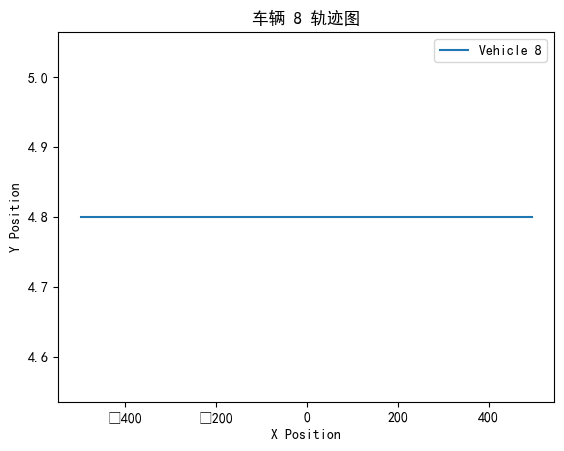

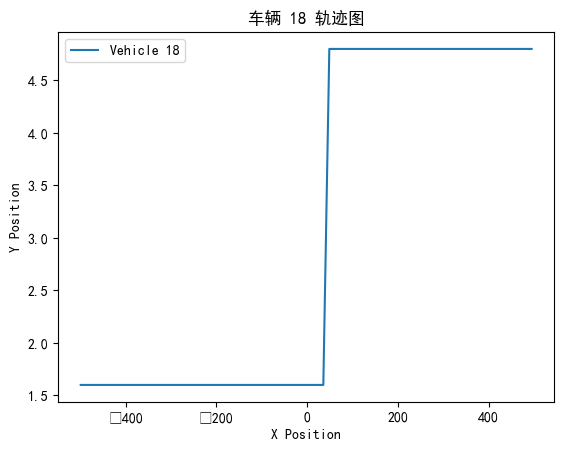

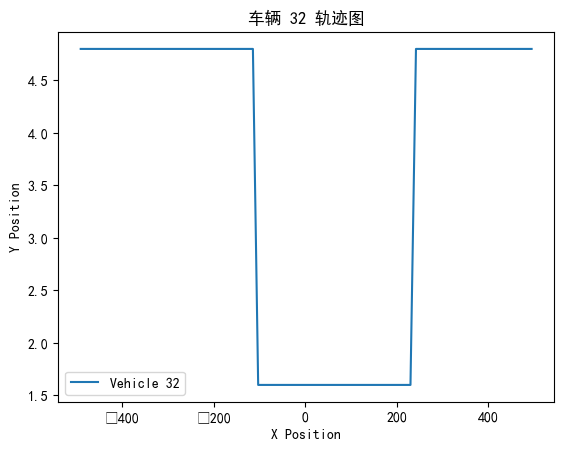

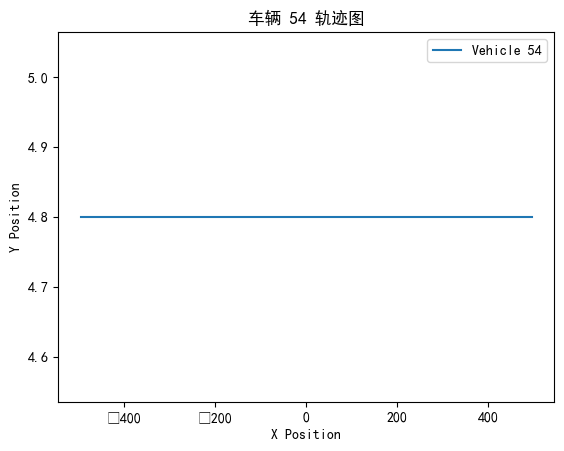

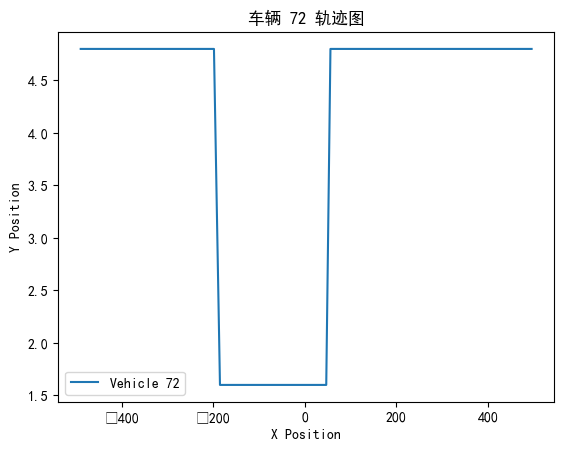

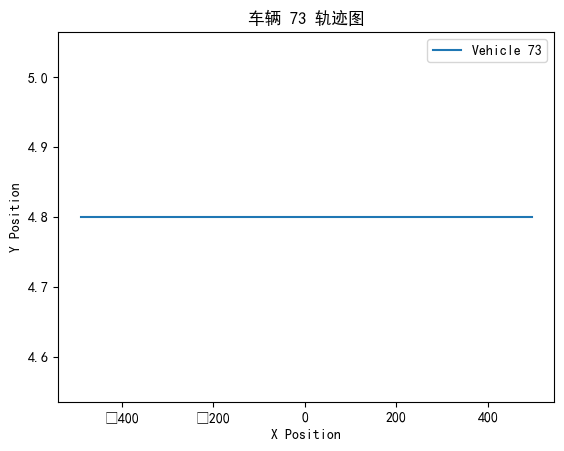

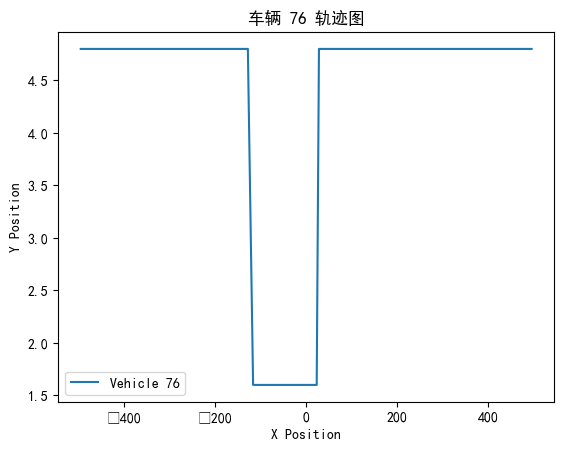

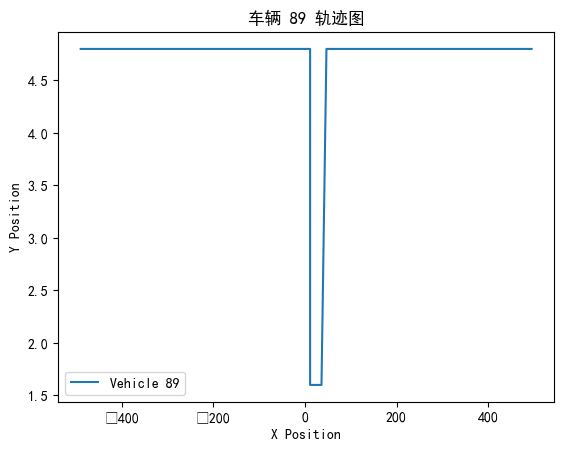

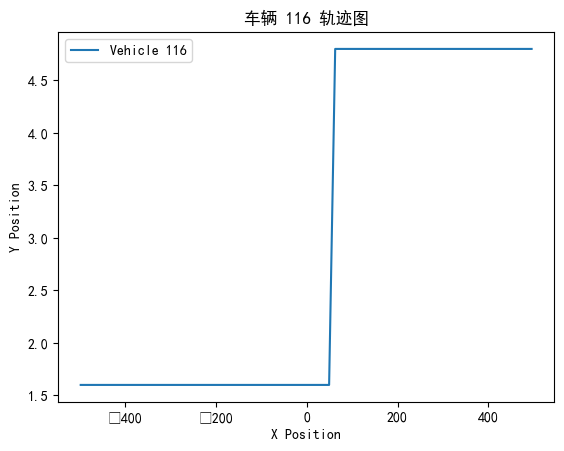

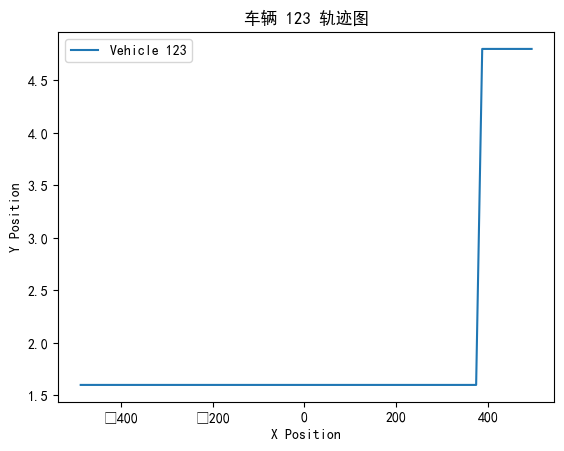

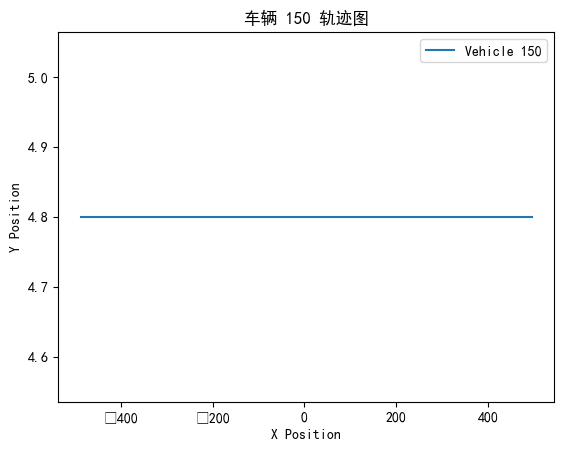

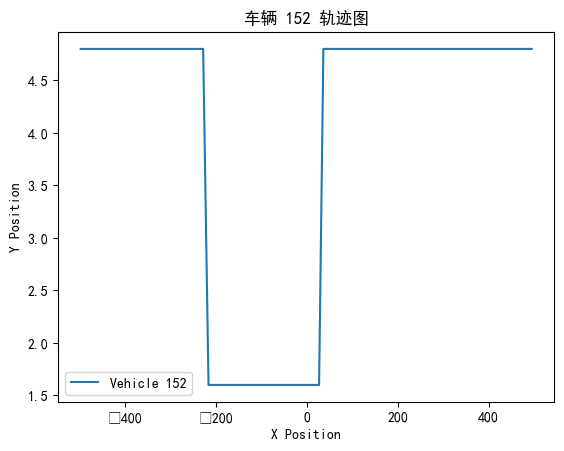

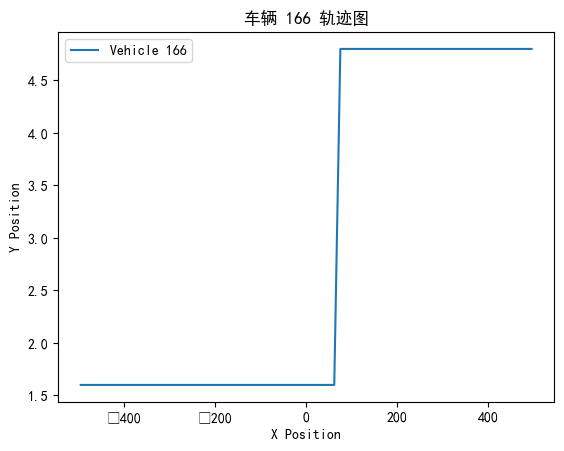

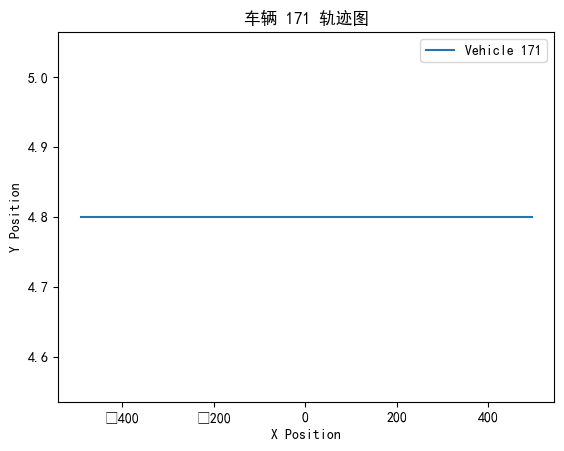

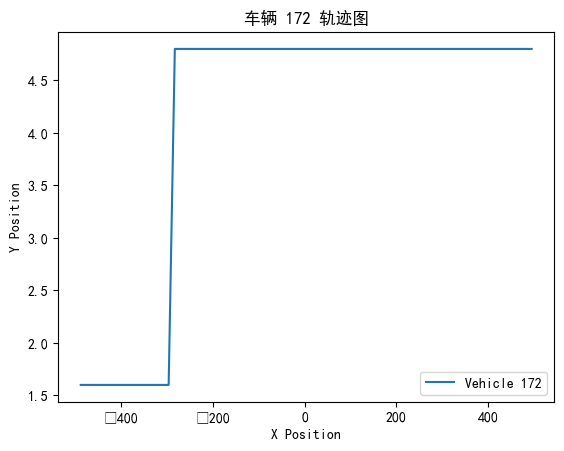

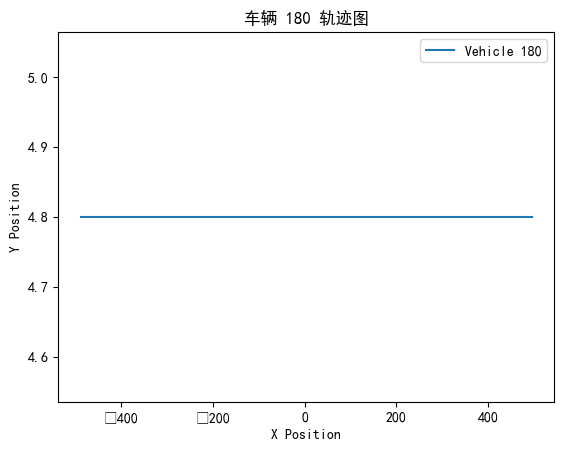

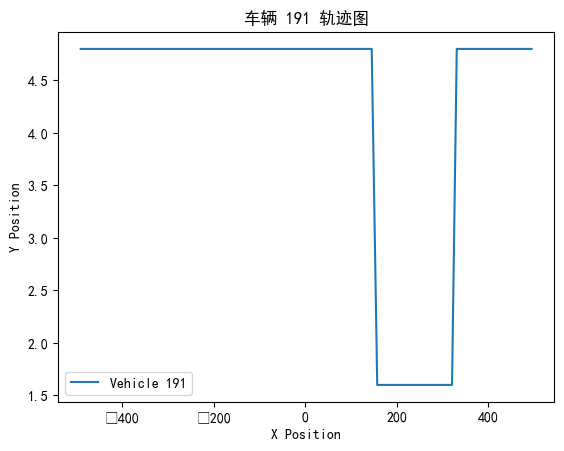

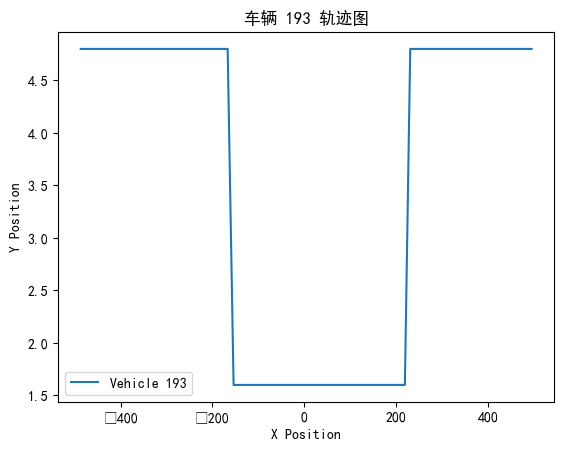

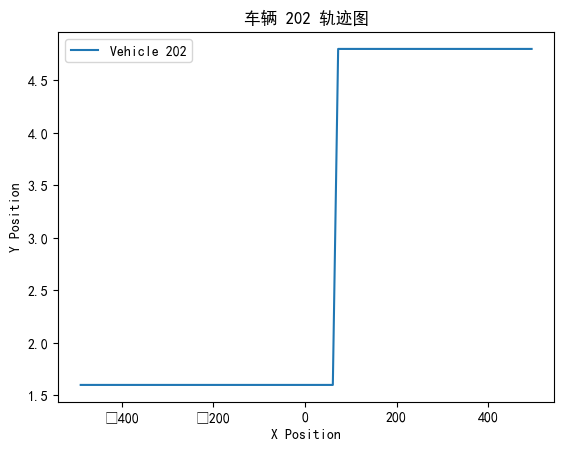

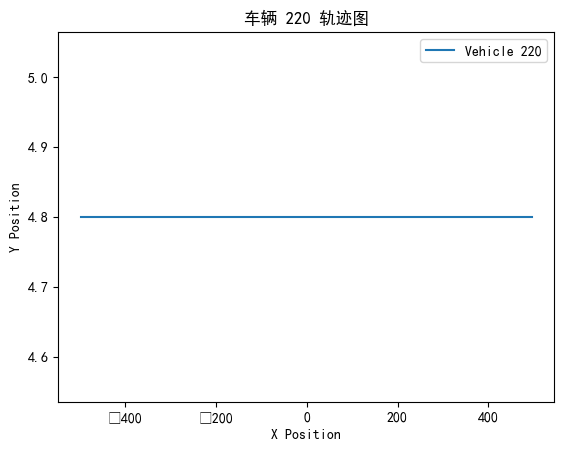

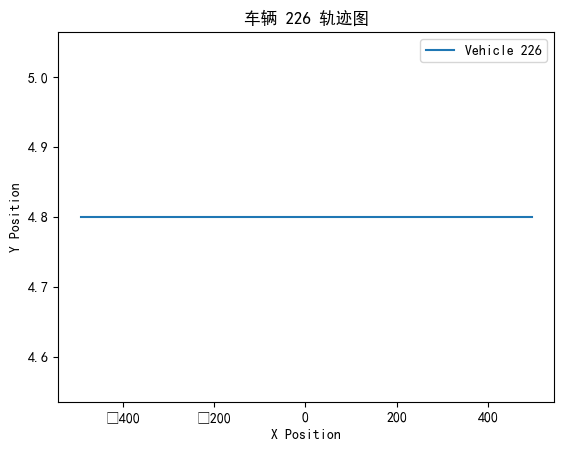

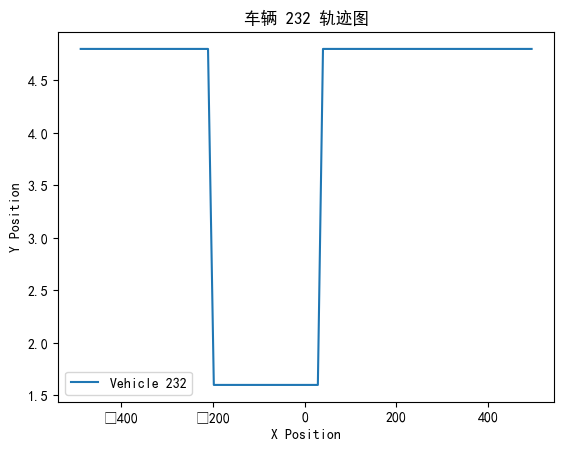

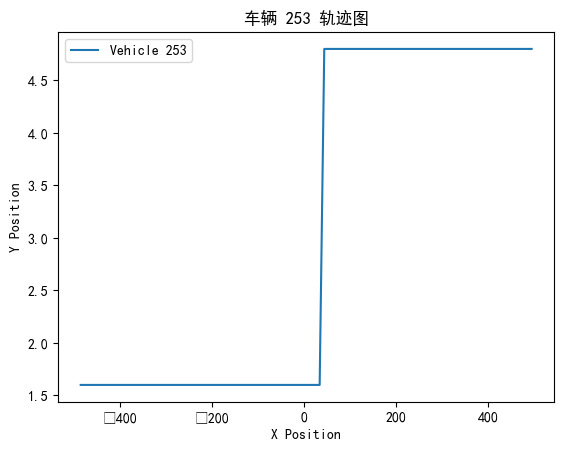

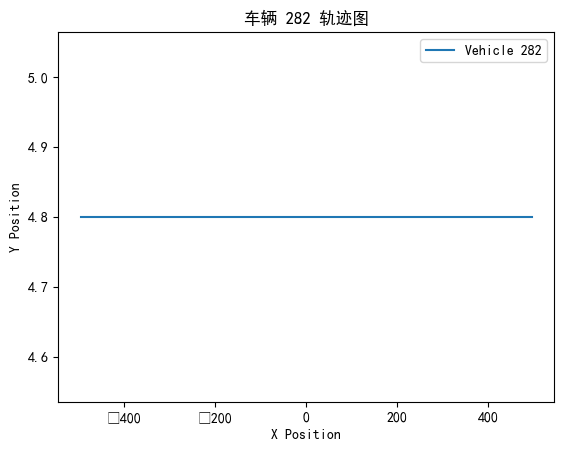

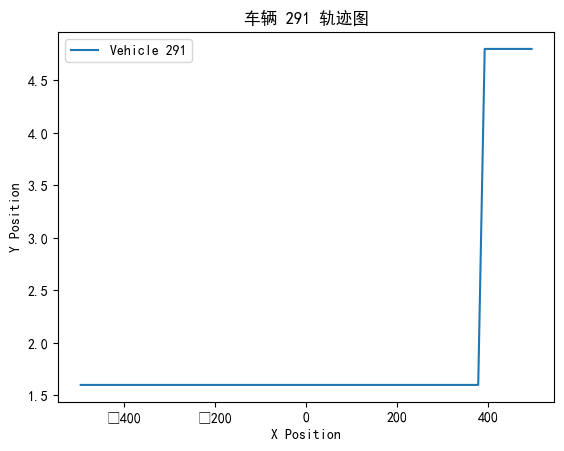

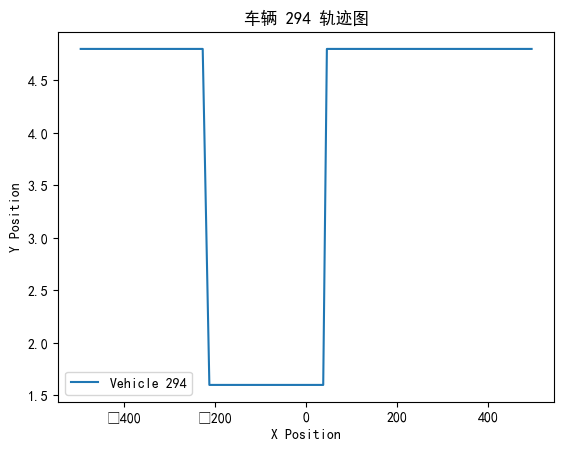

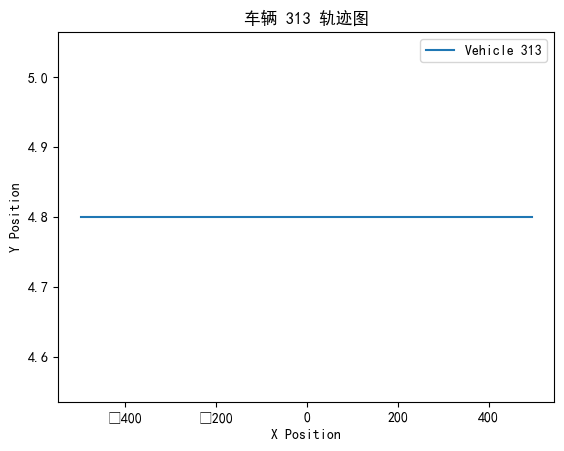

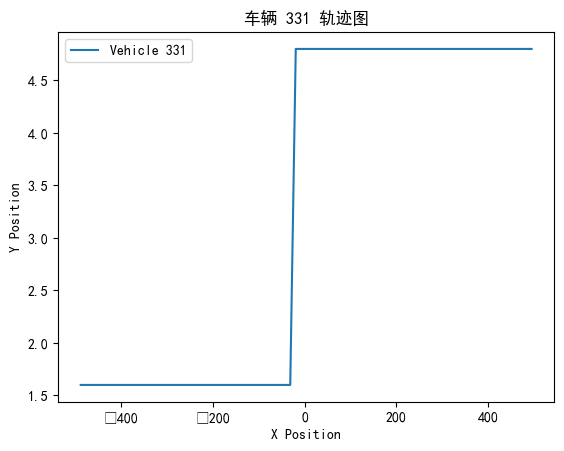

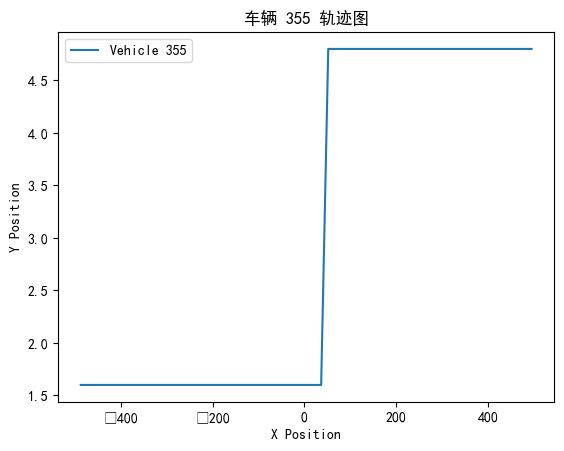

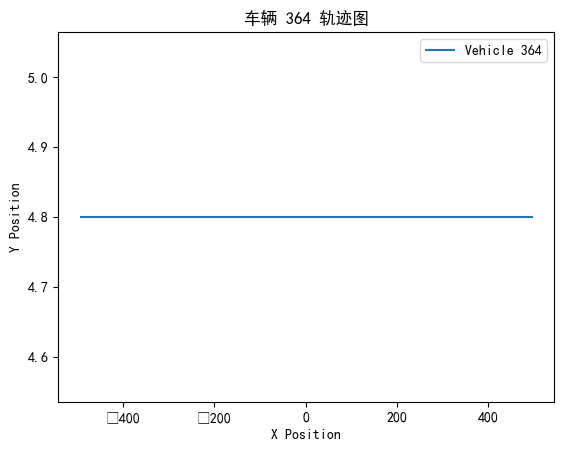

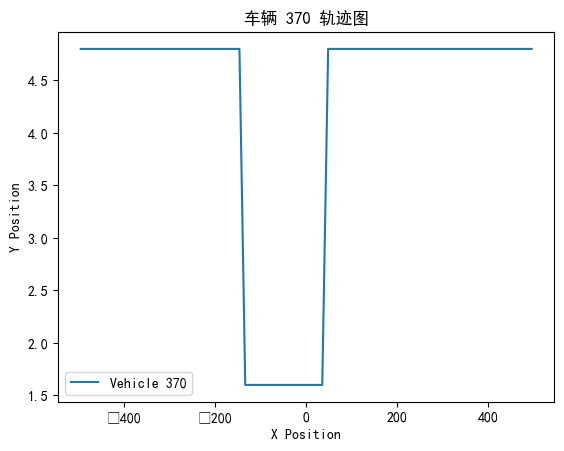

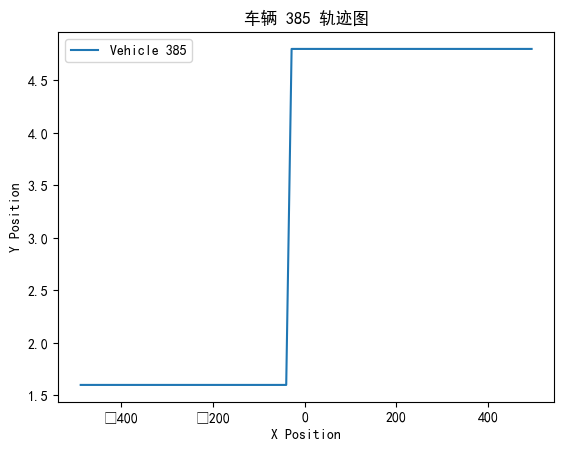

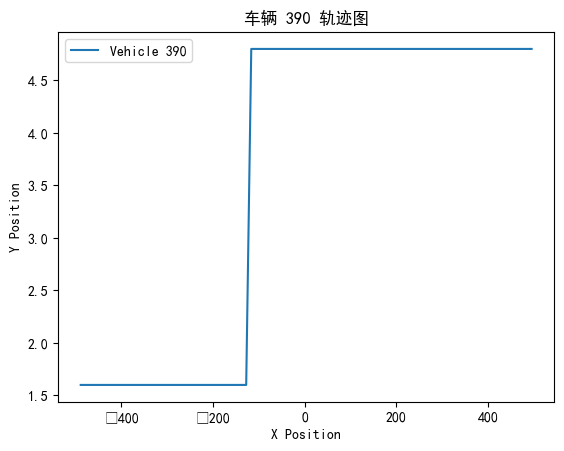

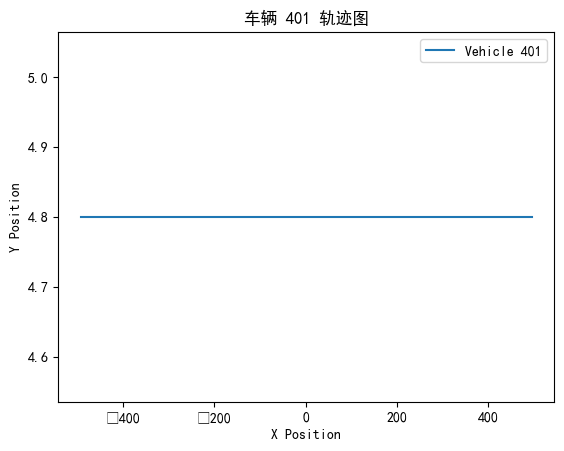

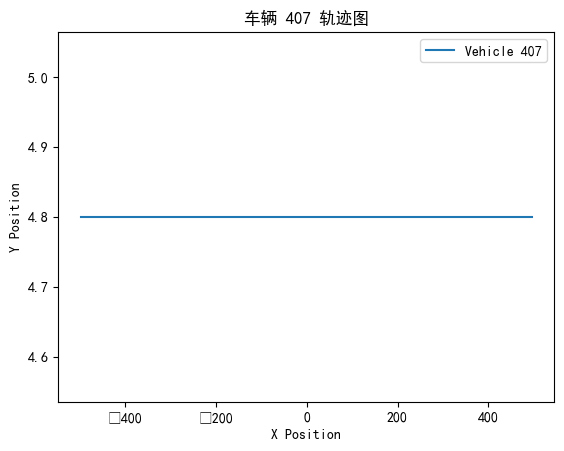

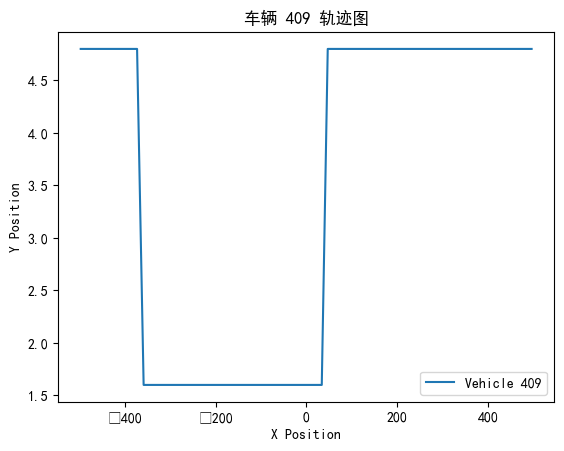

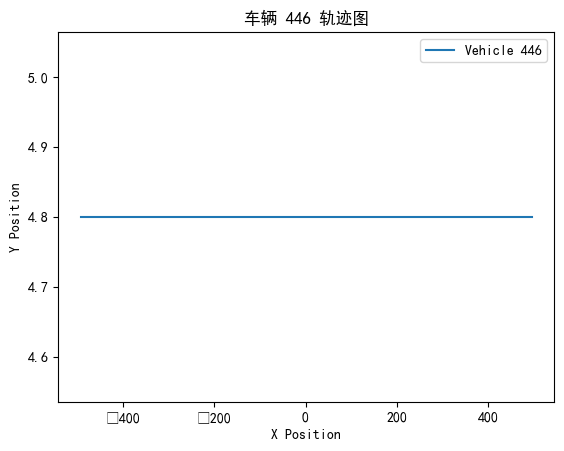

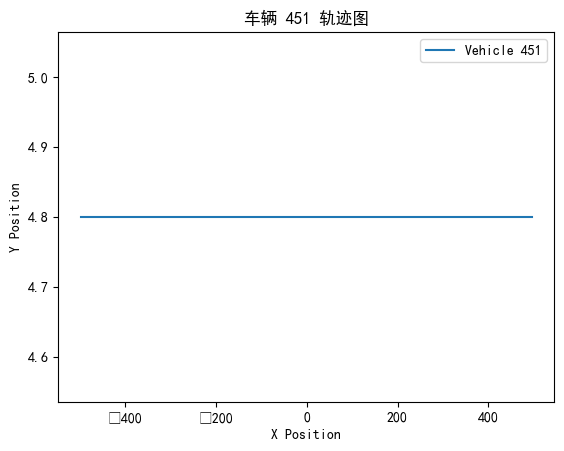

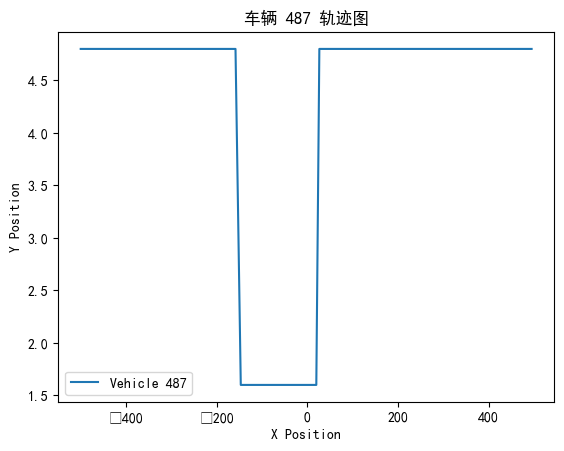

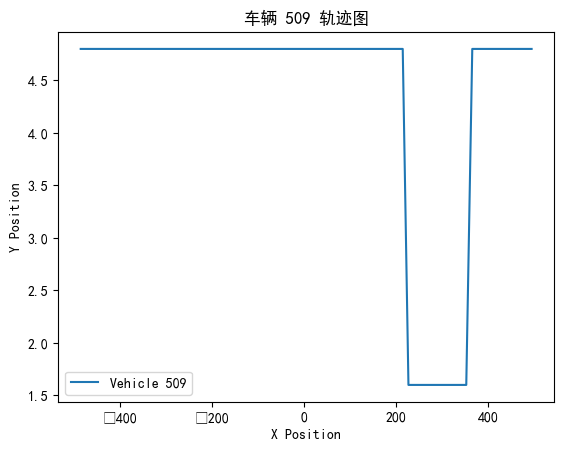

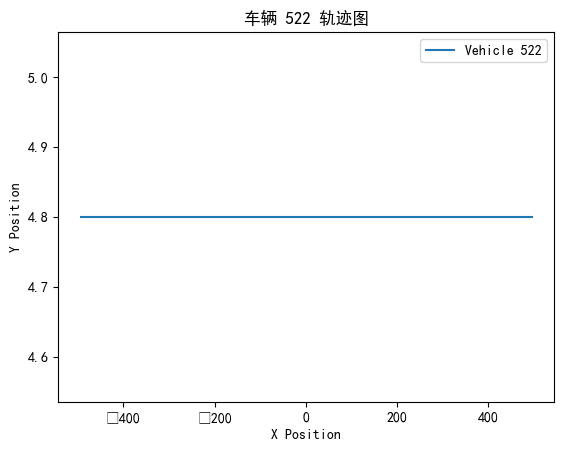

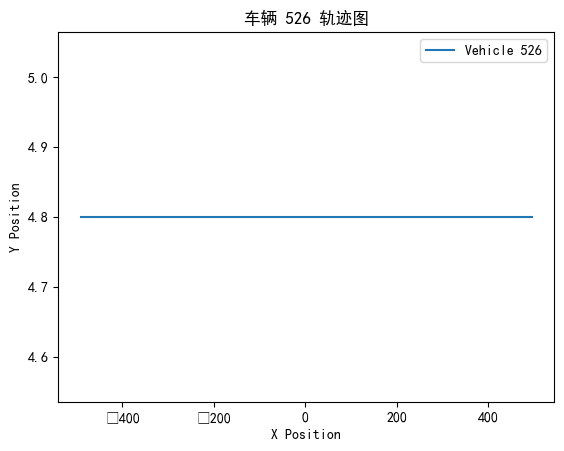

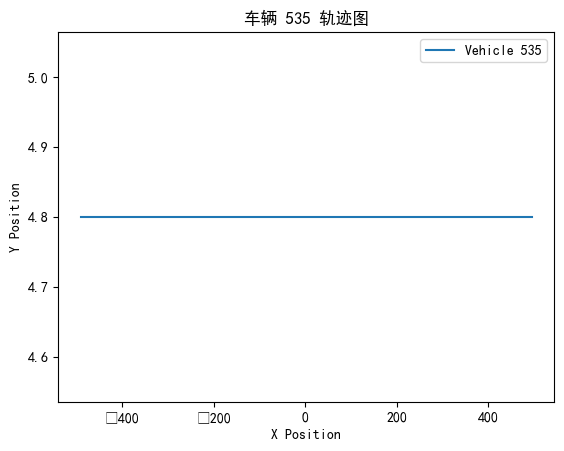

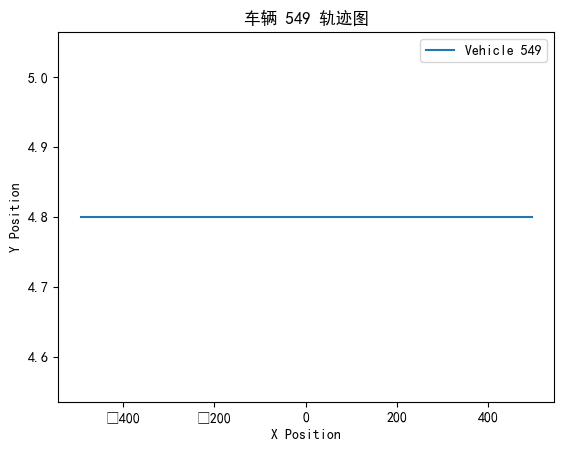

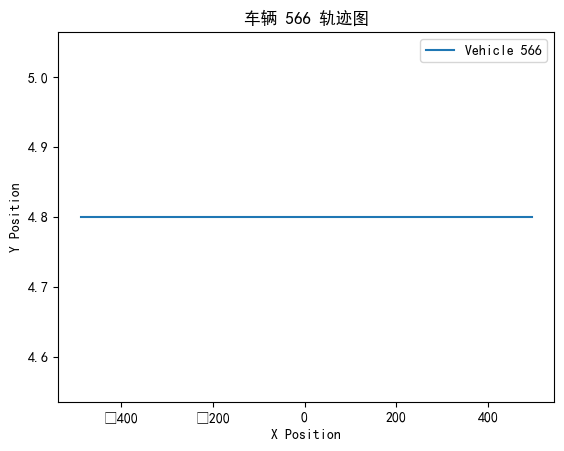

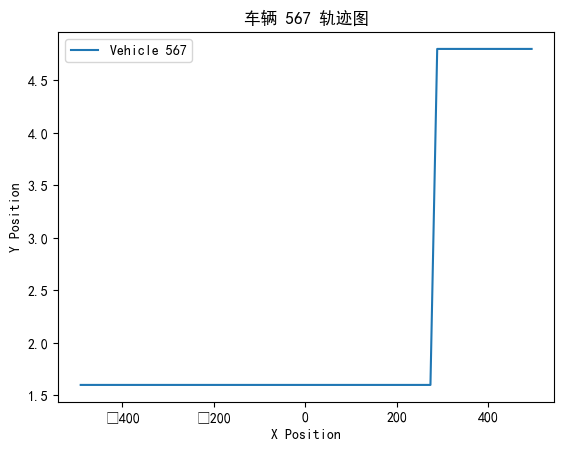

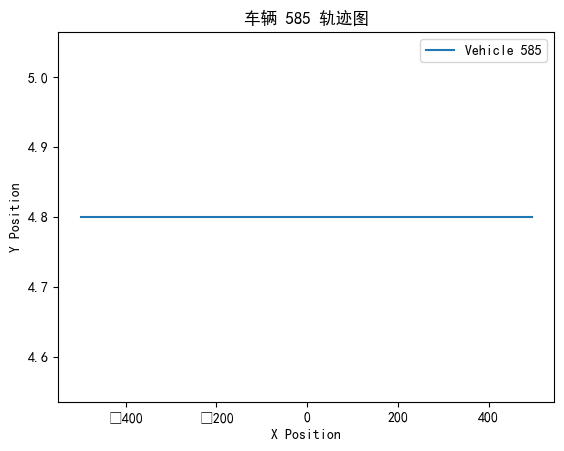

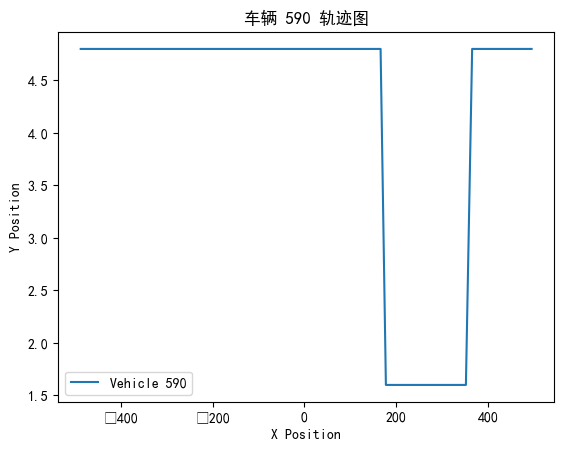

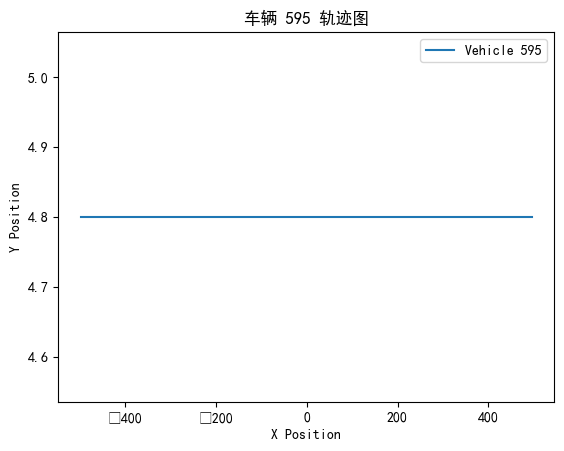

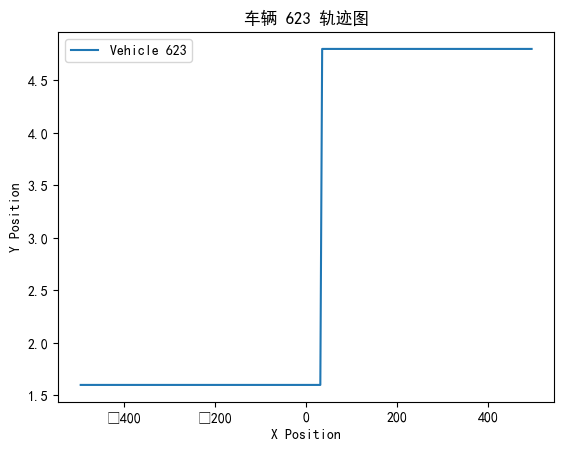

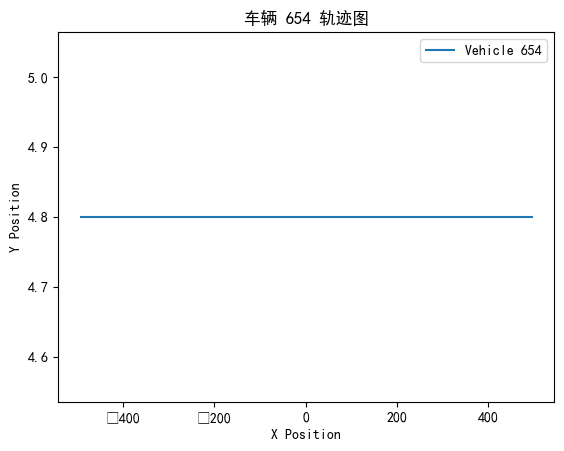

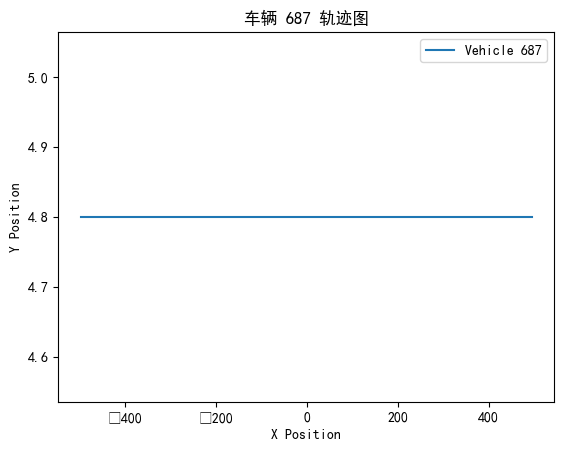

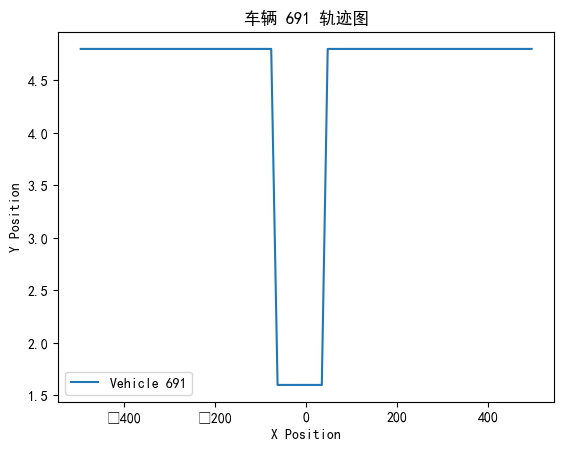

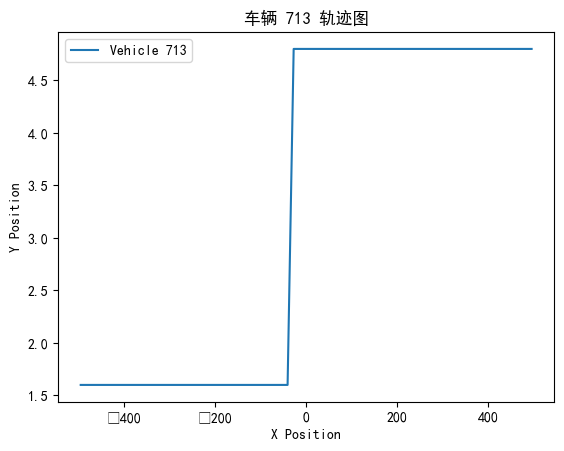

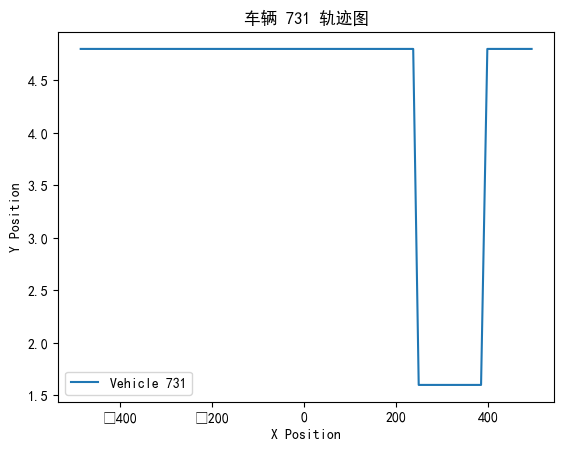

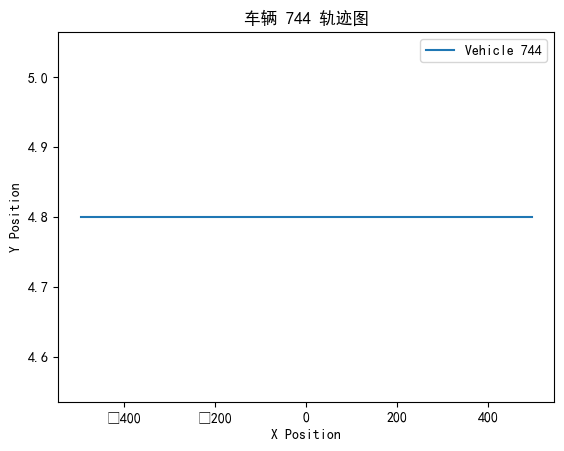

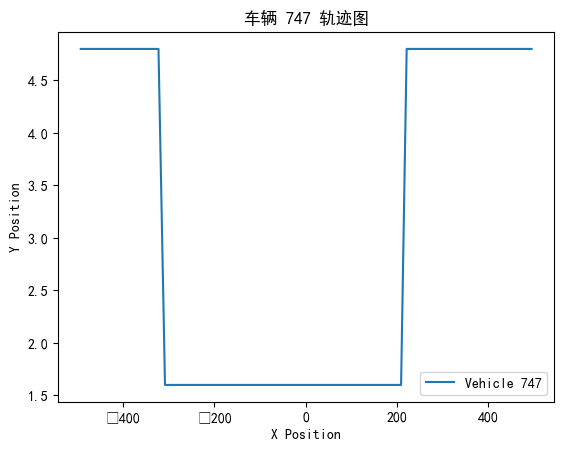

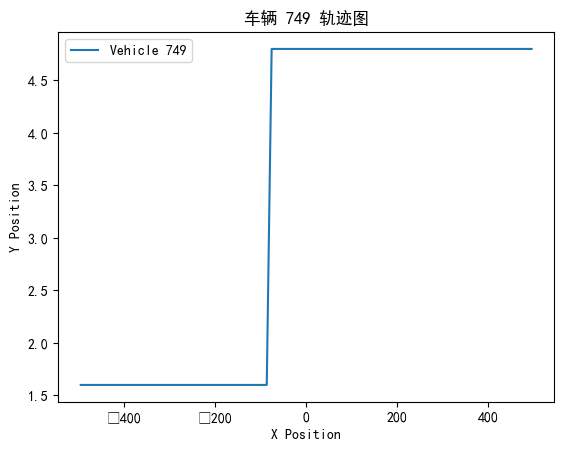

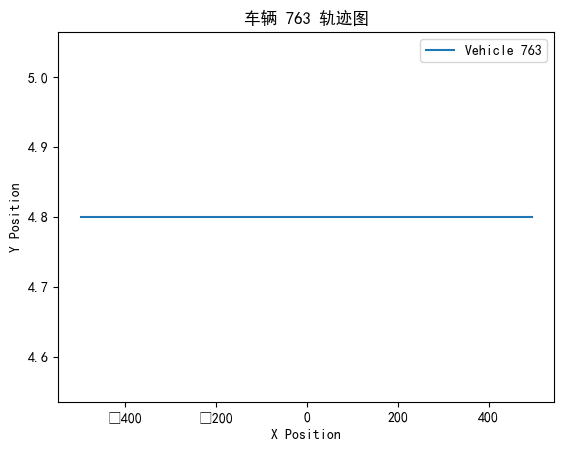

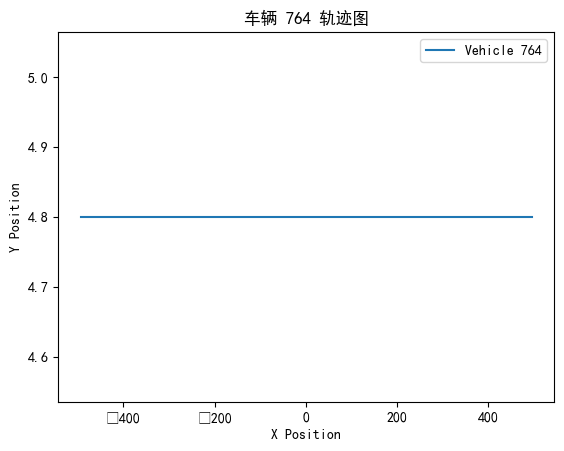

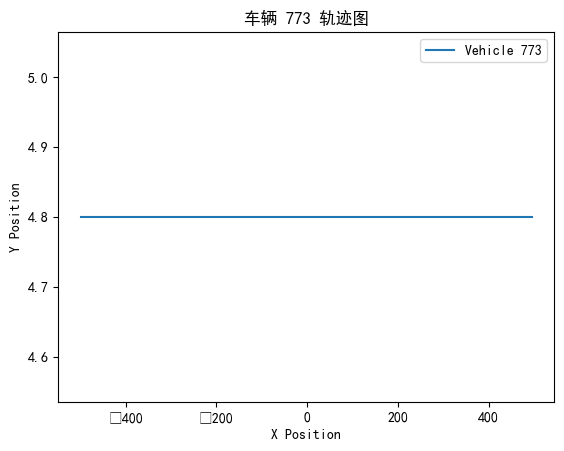

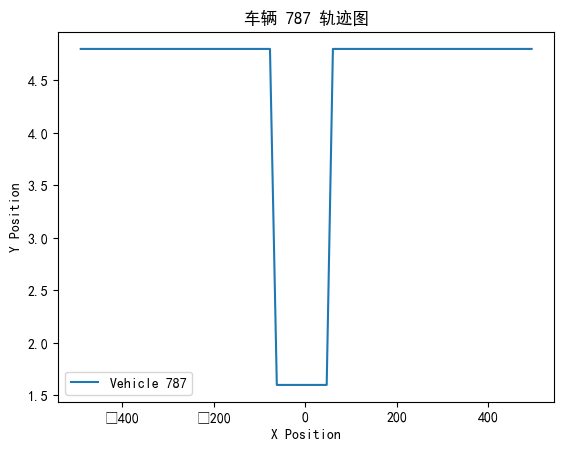

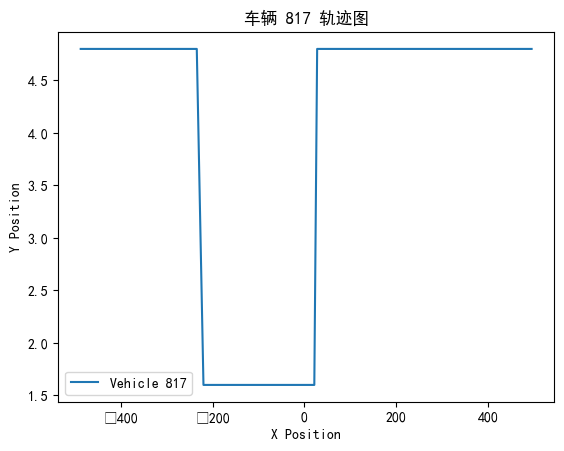

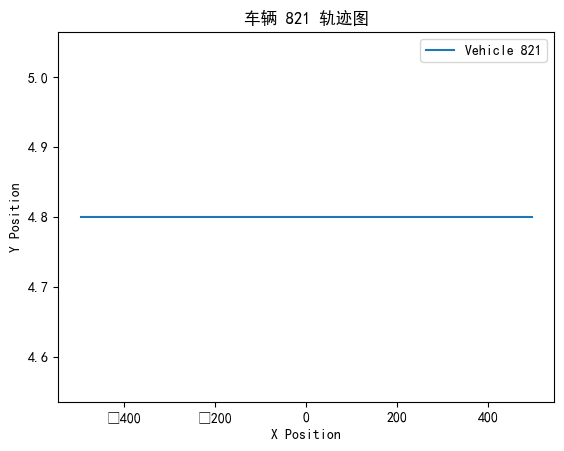

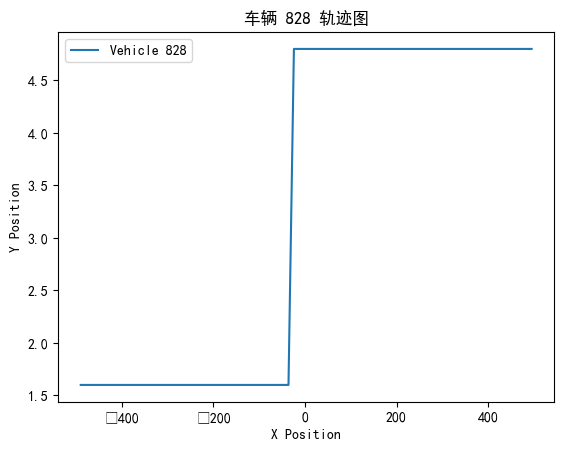

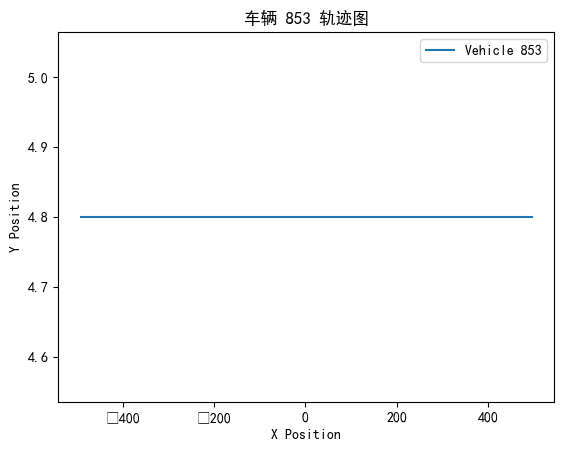

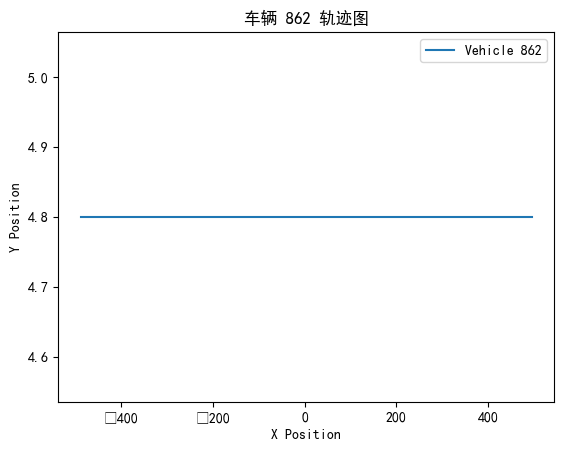

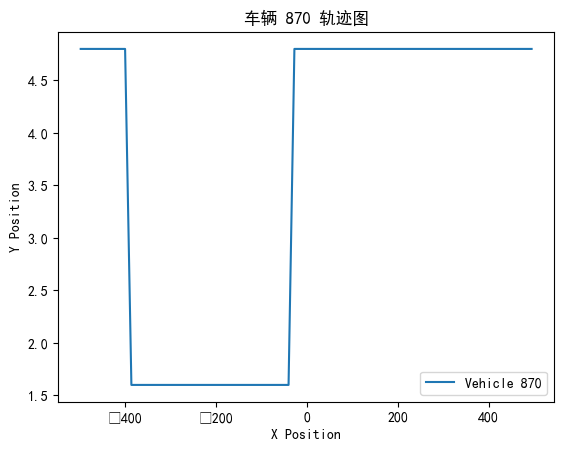

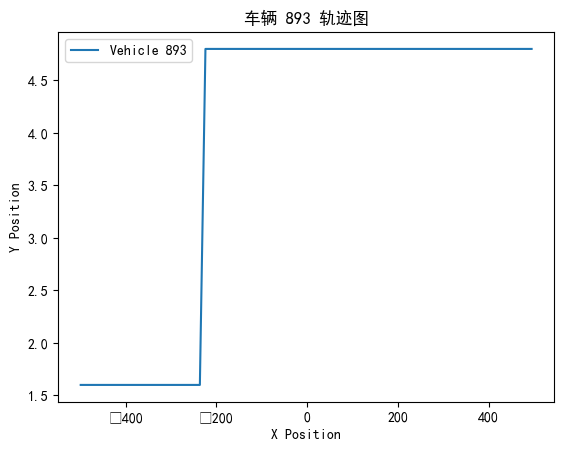

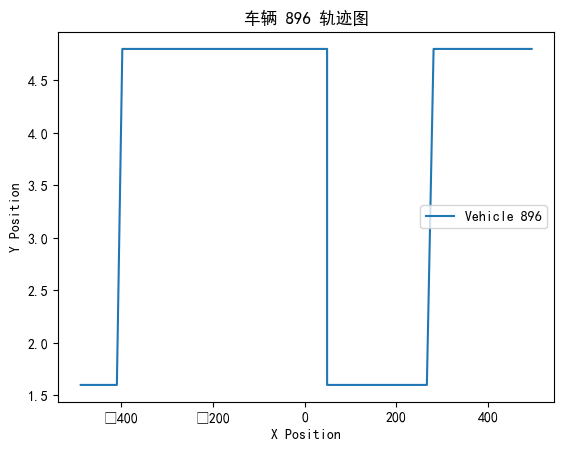

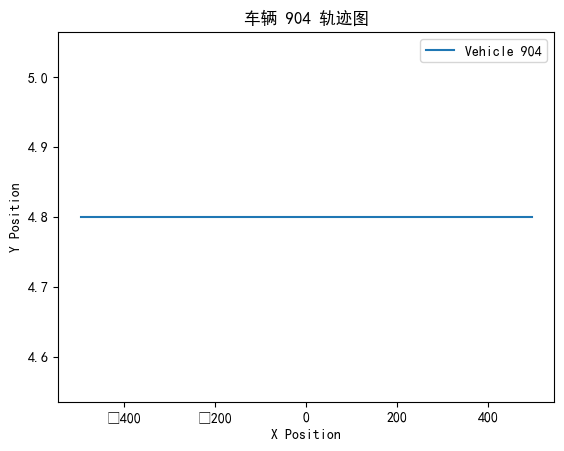

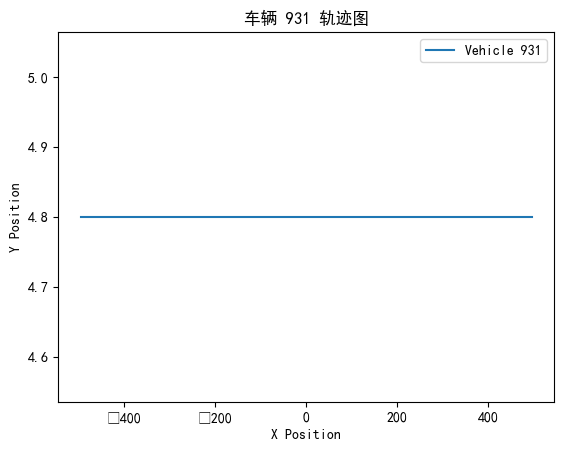

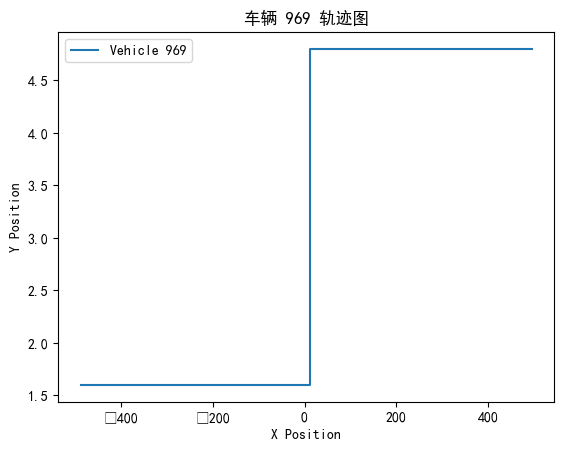

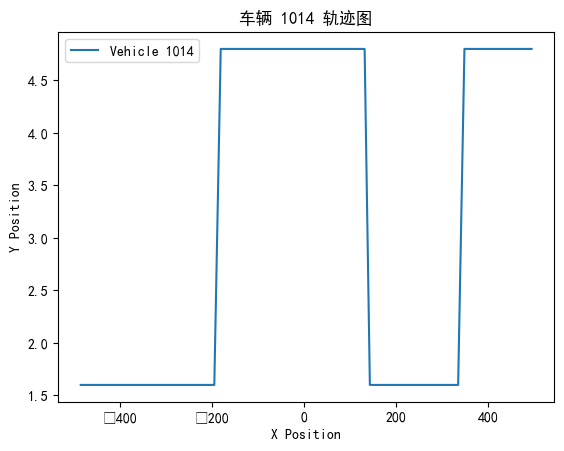

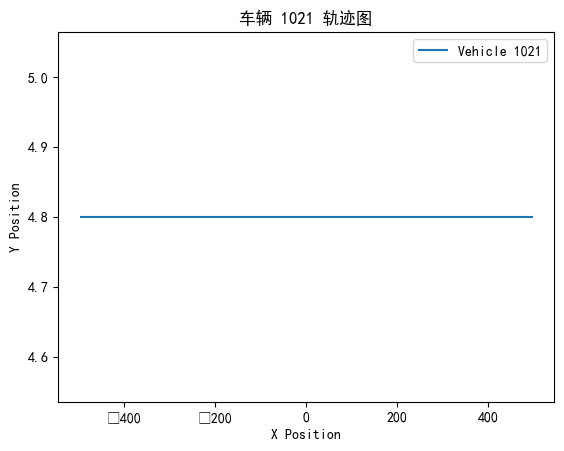

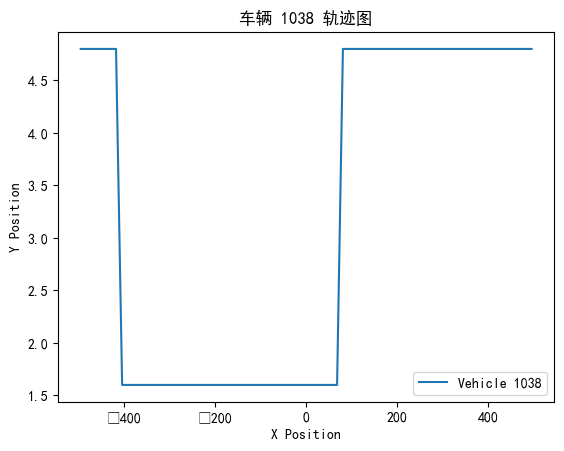

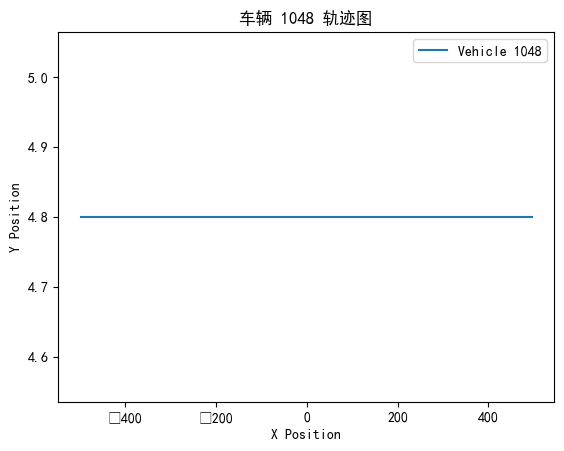

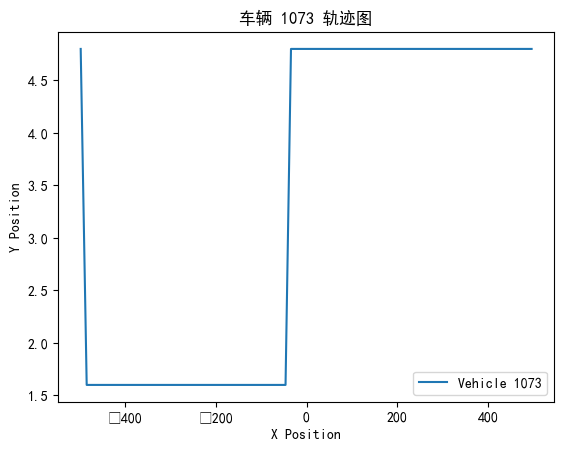

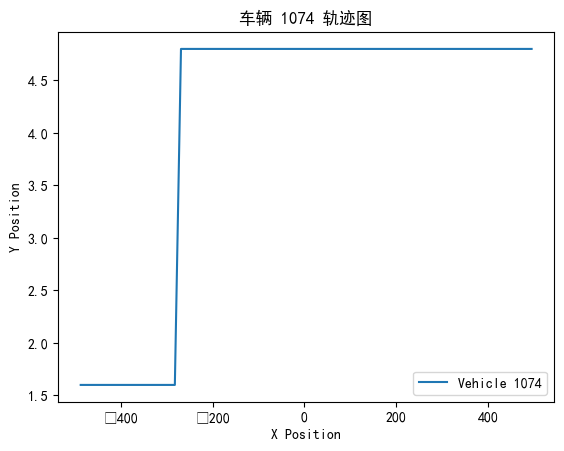

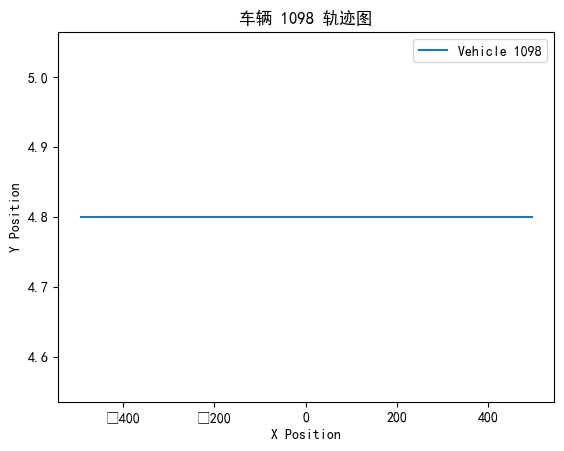

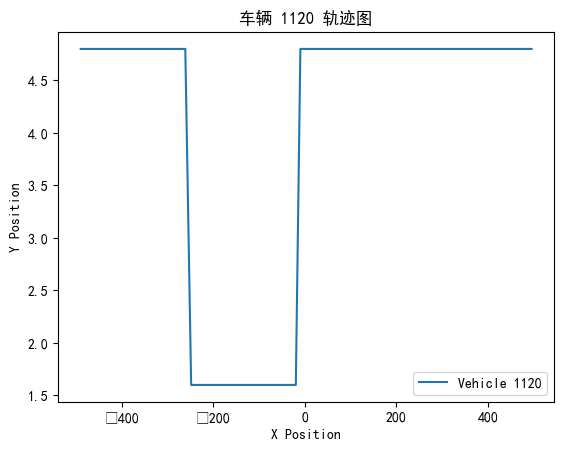

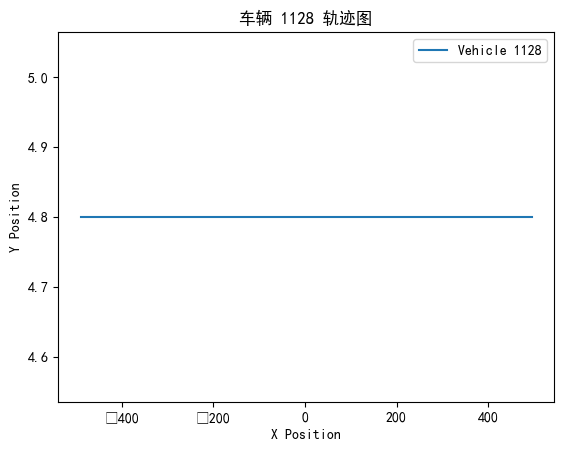

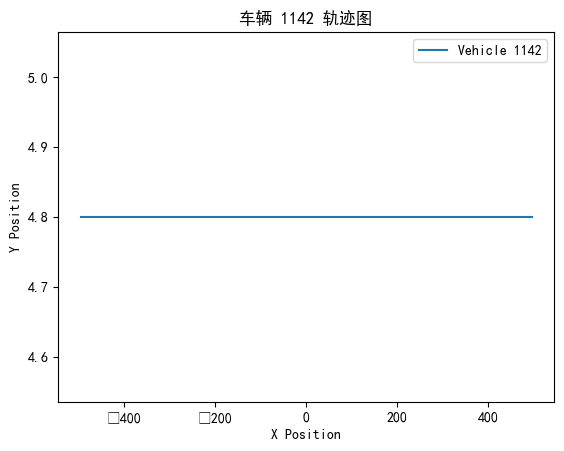

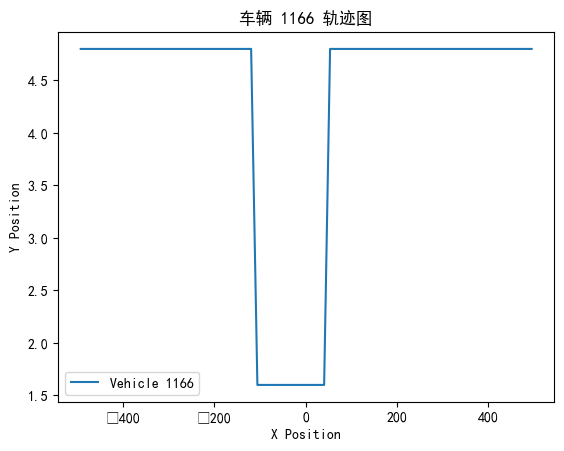

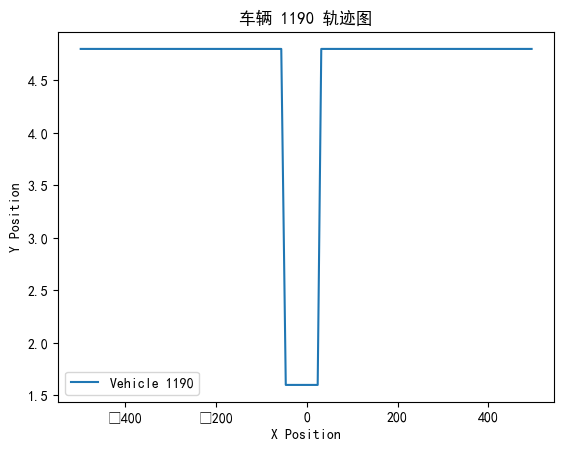

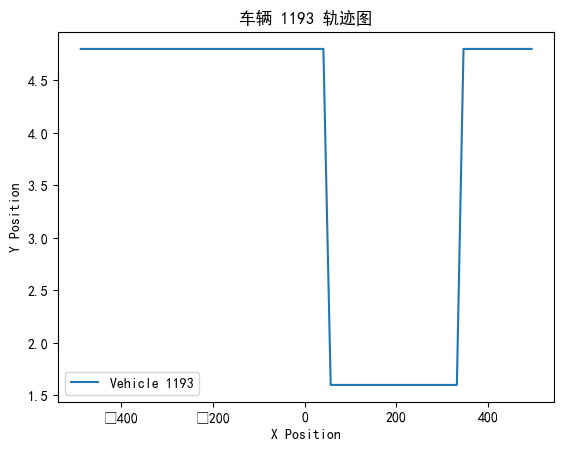

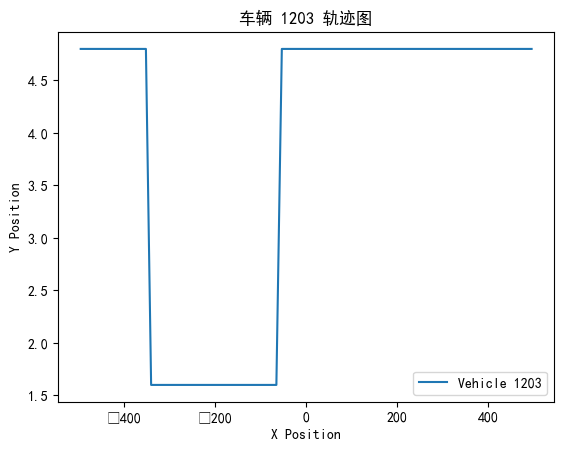

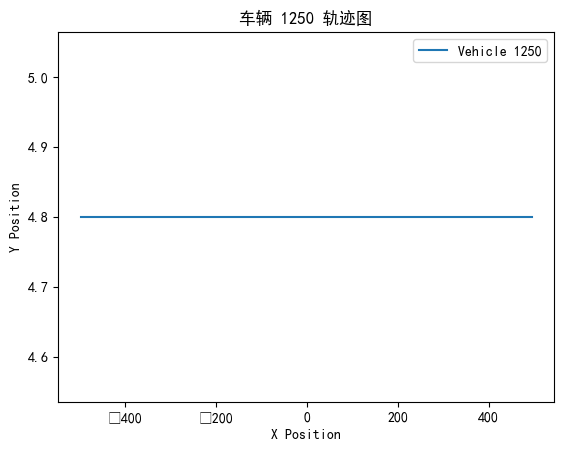

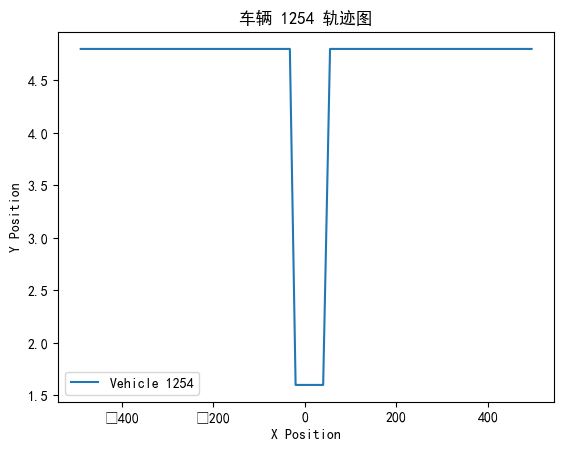

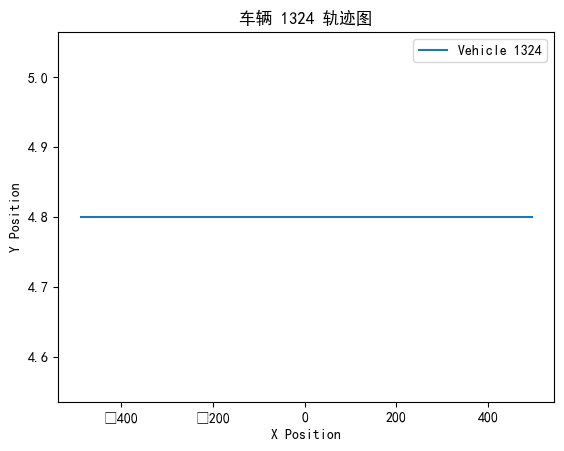

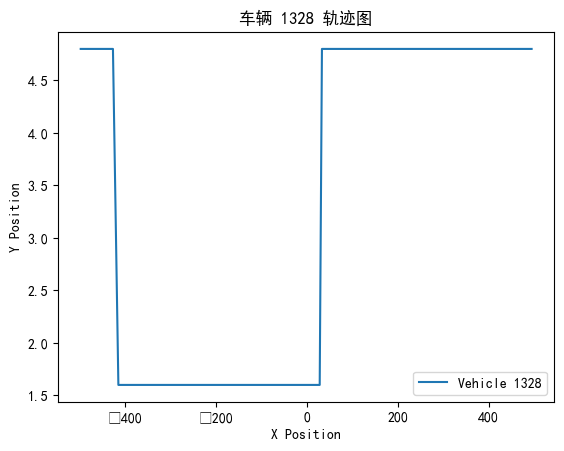

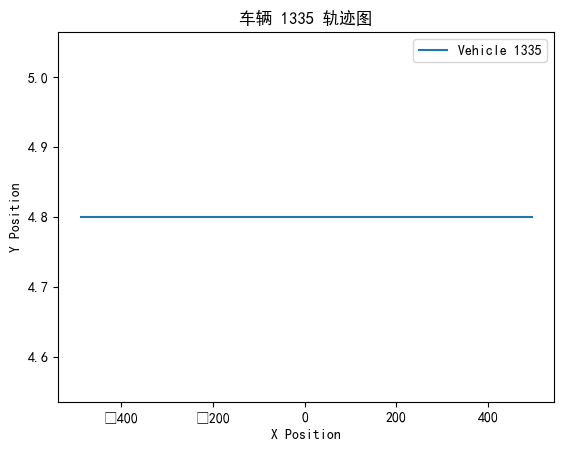

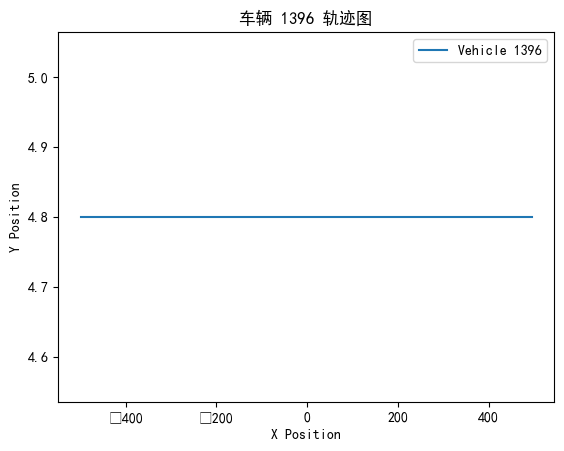

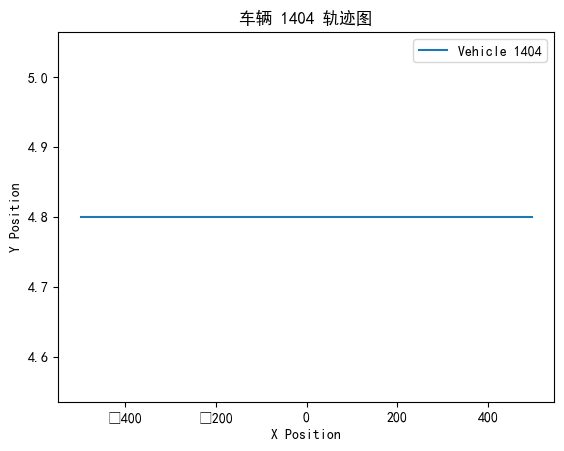

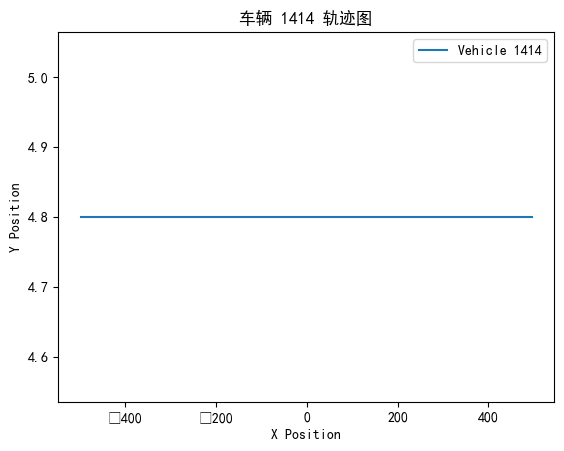

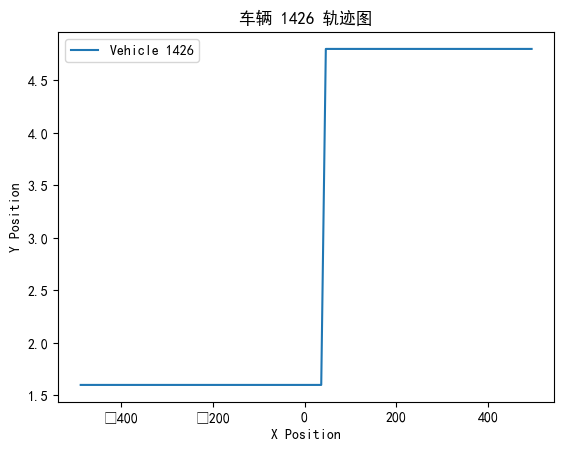

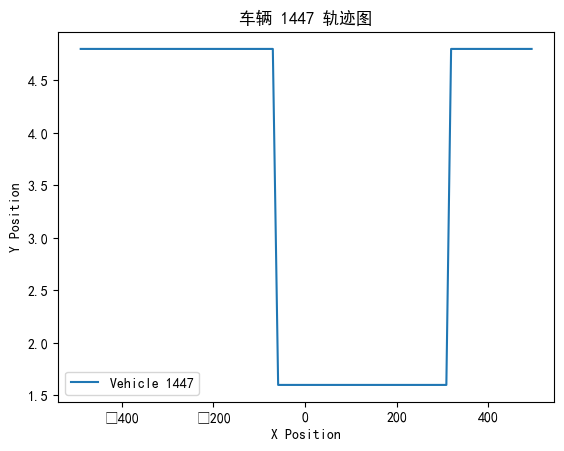

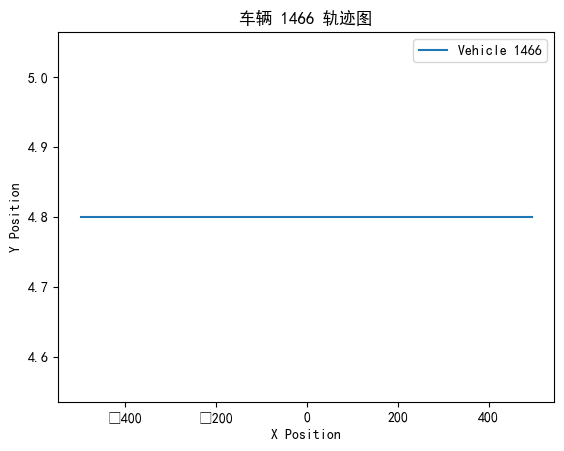

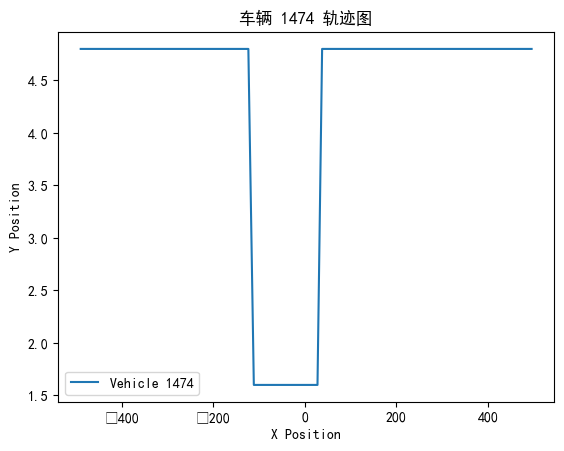

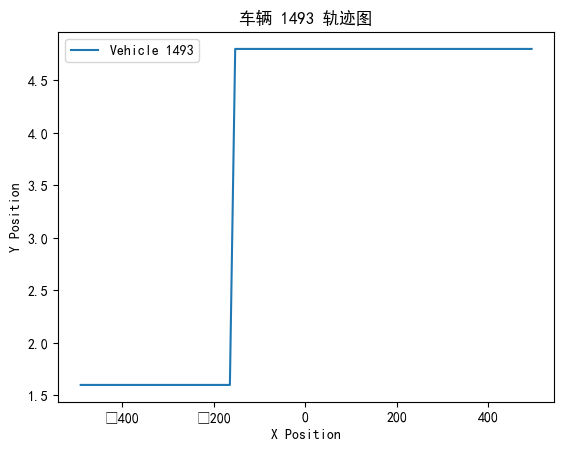

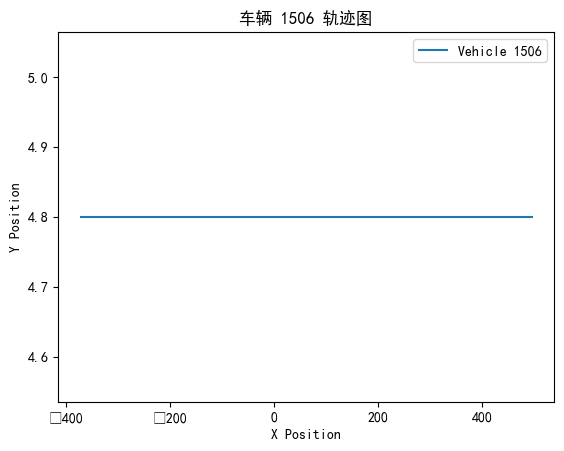

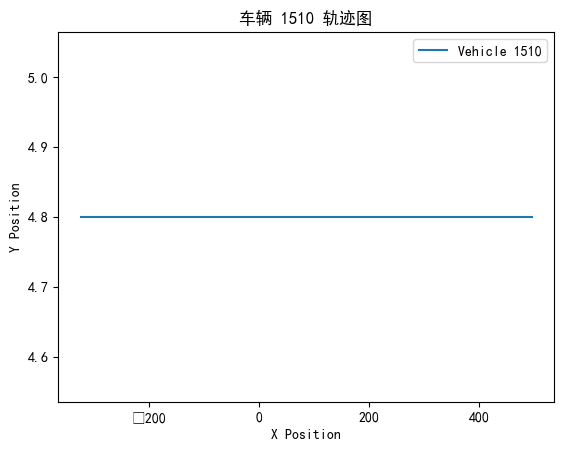

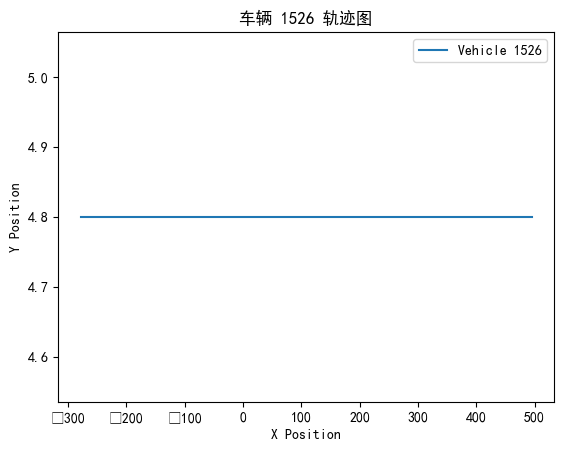

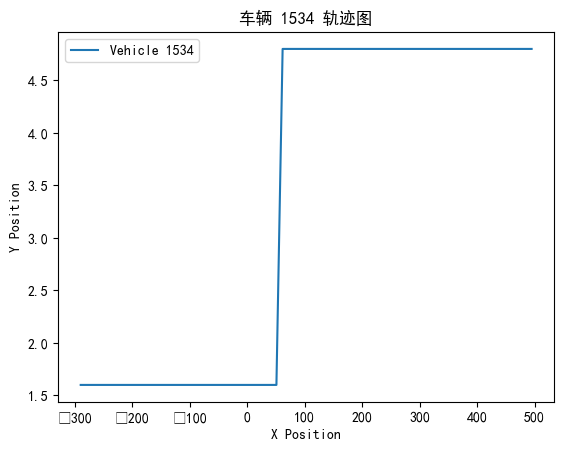

In [3]:
# 为每个车辆ID绘制单独的轨迹图
for vehicle_id, group in df.groupby('vehicle_id'):
    # 创建一个新的图形和坐标轴
    fig, ax = plt.subplots()

    # 设置字体为黑体
    plt.rcParams['font.sans-serif'] = ['SimHei']

    # 绘制轨迹
    ax.plot(group['x'], group['y'], label=f'Vehicle {vehicle_id}')

    # 添加图例
    ax.legend()

    # 设置坐标轴标签
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')

    # 设置标题
    ax.set_title(f'车辆 {vehicle_id} 轨迹图')

    # 显示图形
    plt.show()

### 3、计算红灯周期

最佳参数和轮廓系数: {'eps': 0.060909090909090906, 'min_samples': 1}
Best Silhouette Score: 0.734484321941224


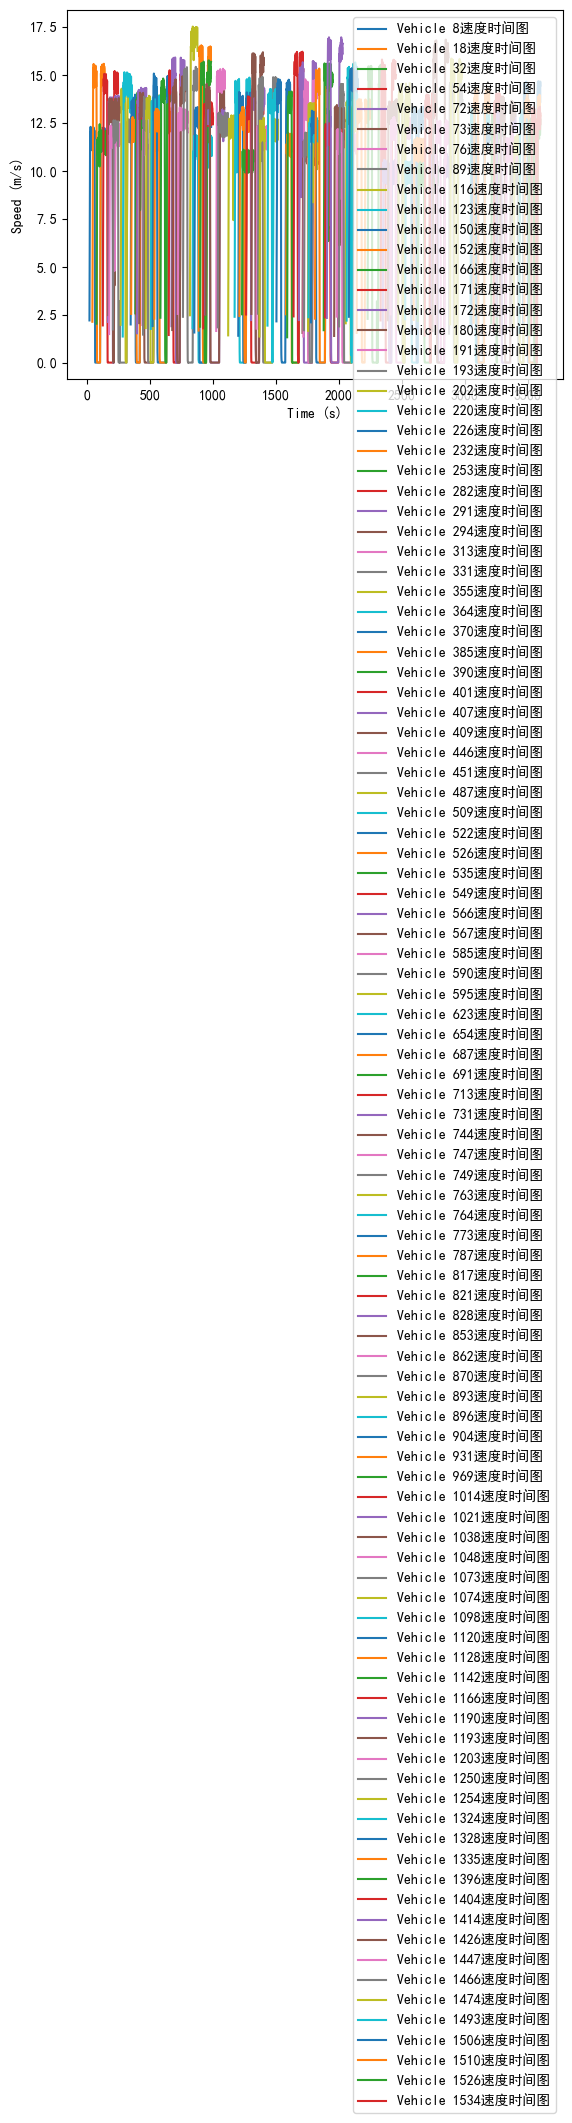

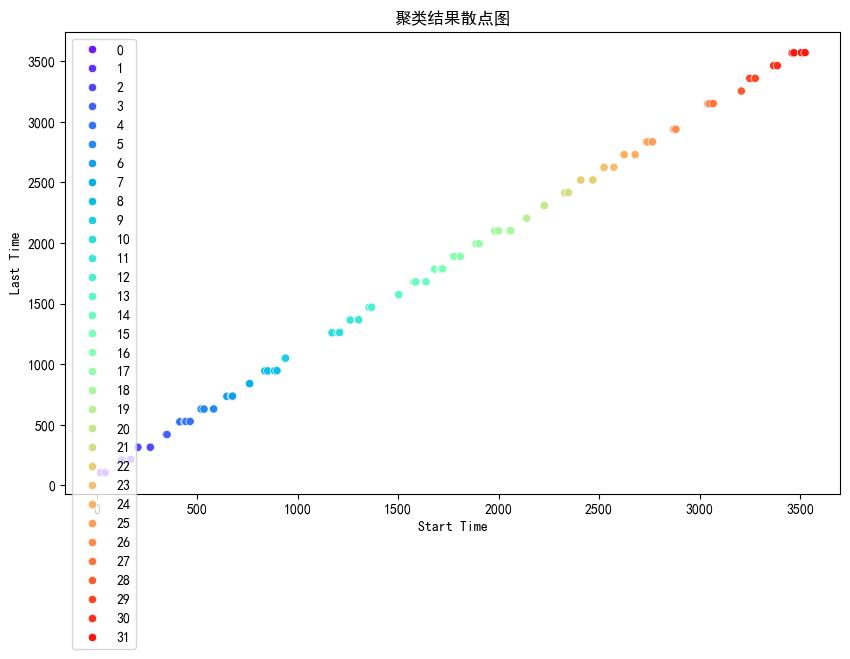

红灯时间： 77.29166666666666


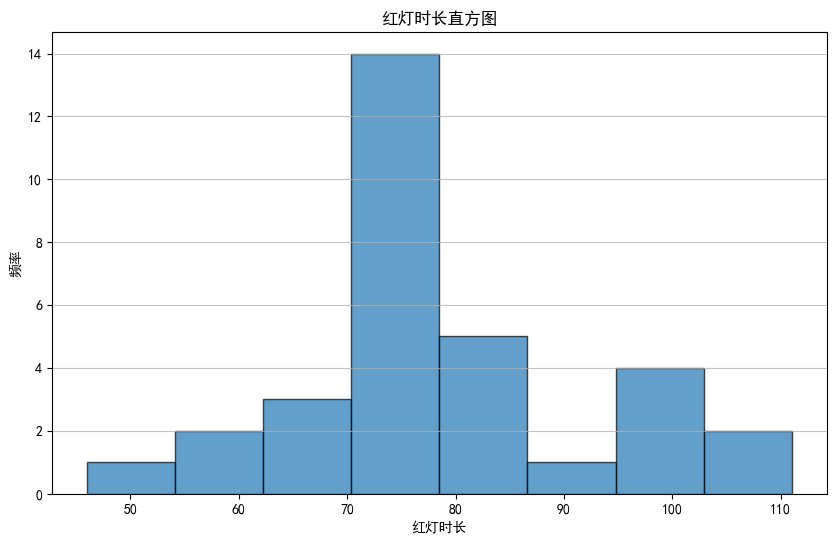

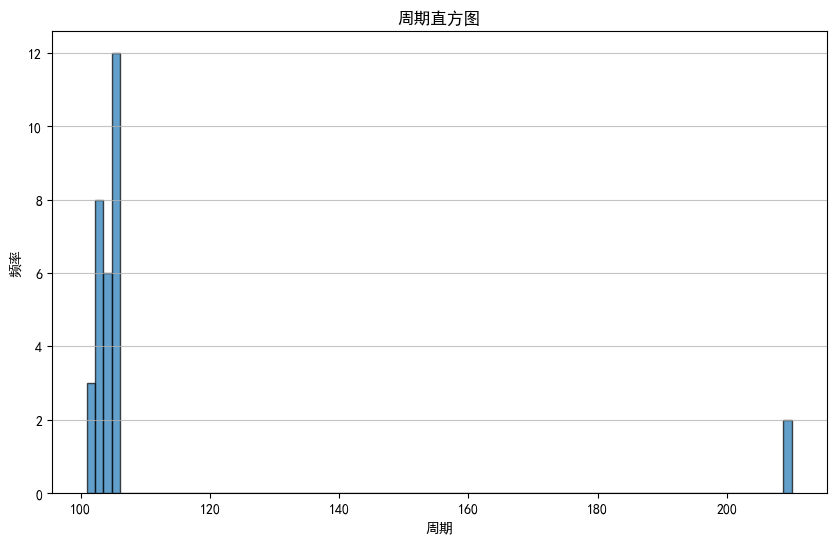

红绿灯周期: 105.43604651162791
绿灯时间: 28.14437984496125


In [4]:
# ********************** 计算速度 时间 ***********************
# 获取所有独特的车辆 ID
data = df
ID = data['vehicle_id'].unique()

#  1：计算车辆速度
for current_vehicle in ID:
    # 提取当前车辆的数据
    vehicle_data = data[data['vehicle_id'] == current_vehicle]

    # 对时间进行排序（确保数据按时间顺序）
    vehicle_data = vehicle_data.sort_values(by='time')

    # 提取 x, y 坐标和时间
    t = vehicle_data['time'].values
    x = vehicle_data['x'].values
    y = vehicle_data['y'].values

    # 计算空间距离差
    dx = np.diff(x)
    dy = np.diff(y)
    dt = np.diff(t)

    # 计算速度
    v = np.sqrt(dx ** 2 + dy ** 2) / dt

    # 绘制速度时间图
    #plt.plot(t[1:], v, label=f'Vehicle {current_vehicle}速度时间图')
    #plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体为黑体
    #plt.xlabel('Time (s)')
    #plt.ylabel('Speed (m/s)')
    #plt.legend()
    # plt.show()

    # 将速度添加到数据集中
    data.loc[data['vehicle_id'] == current_vehicle, 'speed'] = np.concatenate(([0], v))

# 2: 停车检测
speed_threshold = 1  # 速度阈值，单位m/s
start_stop_times = {}  # 存储开始停止的时间点
last_stop_times = {}  # 存储停车的最后一个时间点（速度为0的时刻）

for current_vehicle in ID:
    vehicle_data = data[data['vehicle_id'] == current_vehicle]
    low_speed_indices = np.where(vehicle_data['speed'] <= speed_threshold)[0]

    if len(low_speed_indices) > 0:
        # 开始停止的时间点是速度首次降至或低于阈值的时刻
        start_stop_time = vehicle_data.iloc[low_speed_indices[0]]['time']

        # 查找最后一个速度为0的索引
        zero_speed_indices = np.where(vehicle_data['speed'] == 0)[0]
        # 筛选出低速行驶期间内速度为0的索引
        filtered_zero_speed_indices = zero_speed_indices[
            (zero_speed_indices >= low_speed_indices[0]) & (zero_speed_indices <= low_speed_indices[-1])]

        if len(filtered_zero_speed_indices) > 0:
            # 如果有速度为0的时刻，取最后一个
            last_stop_time = vehicle_data.iloc[filtered_zero_speed_indices[-1]]['time']
        else:
            # 如果没有速度为0的时刻，取特殊值来表示没有停车
            last_stop_time = None

        # 存储结果
        start_stop_times[current_vehicle] = start_stop_time
        last_stop_times[current_vehicle] = last_stop_time

# 3: 筛选有效的停车数据
min_stop_duration = 1  # 最小停车时长，单位秒
filtered_data = []
for vehicle_id, start_time in start_stop_times.items():
    last_time = last_stop_times.get(vehicle_id)
    # 输出结果
    #print(f"Vehicle {vehicle_id}: Started stopping at {start_time}, last stop (speed=0) time at {last_time}")
    # 筛选有效的停车数据，剔除停车时长<10的数据
    if last_time is not None:
        # 计算时间差
        time_diff = last_time - start_time
        if time_diff >= min_stop_duration:
            # 将时间差（或其他特征）添加到列表中
            filtered_data.append((start_time, last_time))


# ******************************* 计算红灯时间及周期 *******************************
# 读取数据
data = pd.DataFrame(filtered_data, columns=['start_time', 'last_time'])
# 特征缩放
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# DBSCAN参数搜索
num_random_search = 100
eps_values = np.linspace(0.01, 0.15, num_random_search)
min_samples_values = np.arange(1, 10)
best_silhouette = -np.inf
best_params = {'eps': None, 'min_samples': None}

for eps in eps_values:
    for min_samples in min_samples_values:
        # 使用当前参数进行DBSCAN聚类
        dbscan_result = DBSCAN(eps=eps, min_samples=min_samples).fit(data_scaled)
        cluster_labels = dbscan_result.labels_

        # 如果聚类结果不是全为-1（即存在非噪声点）
        if len(set(cluster_labels)) > 1:
            silhouette_avg = silhouette_score(data, cluster_labels)
            if silhouette_avg > best_silhouette:
                best_silhouette = silhouette_avg
                best_params['eps'] = eps
                best_params['min_samples'] = min_samples

# 输出最佳参数和轮廓系数
print("最佳参数和轮廓系数:", best_params)
print("Best Silhouette Score:", best_silhouette)

# 使用最佳参数进行聚类
final_dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples']).fit(data_scaled)
final_cluster_labels = final_dbscan.labels_

# 将缩放后的数据转换回 DataFrame 形式（但注意，这里的值已经是缩放后的，不适合直接解释）
data_scaled_df = pd.DataFrame(data_scaled, columns=['start_time', 'last_time'])

# 使用原始数据来计算红灯时长和周期
data_with_labels = pd.DataFrame(data, columns=['start_time', 'last_time'])
data_with_labels['cluster'] = final_cluster_labels

# 使用原始数据来可视化聚类结果
plt.figure(figsize=(10, 6))
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体为黑体
sns.scatterplot(data=data_with_labels, x='start_time', y='last_time',
                hue=pd.Categorical.from_codes(final_cluster_labels, categories=np.unique(final_cluster_labels)),
                palette='rainbow')
plt.title("聚类结果散点图")
plt.xlabel("Start Time")
plt.ylabel("Last Time")
plt.show()

###################################### 红灯时长 ##################################################
# 计算每个簇的红灯时长平均值
red_light_durations = {}
for cluster in np.unique(final_cluster_labels):
    if cluster != -1:  # 忽略噪声点
        cluster_data = data_with_labels[data_with_labels['cluster'] == cluster]
        red_light_durations[cluster] = cluster_data['last_time'].subtract(cluster_data['start_time']).mean()

# 计算过滤后簇的红灯时长最大值
median_red_light_duration = np.median(list(red_light_durations.values())) # np.max(问题4)
print("红灯时间：", median_red_light_duration)

# 绘制红灯时长直方图
plt.figure(figsize=(10, 6))
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体为黑体
cluster_durations = list(red_light_durations.values())
plt.hist(cluster_durations, bins='auto', alpha=0.7, edgecolor='black')
plt.xlabel('红灯时长')
plt.ylabel('频率')
plt.title('红灯时长直方图')
plt.grid(axis='y', alpha=0.75)
plt.show()


##################################### 红绿灯周期 #################################
# 找出每个簇中的时间点'last_time'（作为周期结束的代表）
# 因为每个簇代表一波车流
# 首先，我们创建一个字典来存储每个簇的 'last_time' 的最大值和最小值
cluster_last_time_extremes = {}
for cluster in np.unique(final_cluster_labels):
    if cluster != -1:
        cluster_data = data_with_labels[data_with_labels['cluster'] == cluster]
        cluster_last_time_extremes[cluster] = {'min': cluster_data['last_time'].min(),
                                               'max': cluster_data['last_time'].max()}

# 计算簇与簇之间'last_time'的差（作为周期），使用第二个簇的最小值减去第一个簇的最大值
periods = []
clusters = sorted(cluster_last_time_extremes.keys())
for i in range(len(clusters) - 1):
    diff = cluster_last_time_extremes[clusters[i + 1]]['min'] - cluster_last_time_extremes[clusters[i]]['max']
    periods.append(diff)

# 绘制周期直方图
plt.figure(figsize=(10, 6))
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体为黑体
plt.hist(periods, bins='auto', alpha=0.7, edgecolor='black')
plt.xlabel('周期')
plt.ylabel('频率')
plt.title('周期直方图')
plt.grid(axis='y', alpha=0.75)
plt.show()

# 使用 numpy 的 histogram 函数找到频率最高的周期
counts, bin_edges = np.histogram(periods, bins='auto')
max_index = np.argmax(counts)  # 找到计数最多的bin的索引
most_common_period_bin = 0.5 * (bin_edges[max_index] + bin_edges[max_index + 1])  # 计算该bin的中心点作为周期的代表
if most_common_period_bin > 500:
    most_common_period_bin = most_common_period_bin/5
elif most_common_period_bin > 400:
    most_common_period_bin = most_common_period_bin / 4
elif most_common_period_bin > 300:
    most_common_period_bin = most_common_period_bin / 3
elif most_common_period_bin > 200:
    most_common_period_bin = most_common_period_bin / 2
elif most_common_period_bin > 150:
    most_common_period_bin = most_common_period_bin / 2
print(f"红绿灯周期: {most_common_period_bin}")  # 最常见的周期 bin 相对应的中位数

# 计算绿灯时间
green = most_common_period_bin - median_red_light_duration
print(f"绿灯时间: {green}")

# 结果：
#"A1: 红灯时间：77, 绿灯时间：28"
#"A2: 红灯时间：72, 绿灯时间：45"
#"A3: 红灯时间：81, 绿灯时间：23"
#"A4: 红灯时间：75, 绿灯时间：13"   # 综合考虑，红灯时间必定小于周期，所以观察直方图，取频率第二且红灯时间小于周期的数据的中位数
#"A5: 红灯时间：71, 绿灯时间：17"   # 综合考虑，红灯时间必定小于周期，所以观察直方图，取频率第二且红灯时间小于周期的数据的中位数

### 4、在考虑车流量、定位误差等影响因素的情况下 计算红灯周期

#### （1）定位误差

原始离群点计数: x    1442.0
y       0.0
dtype: float64
处理后离群点计数: x    0.0
y    0.0
dtype: float64
查看缺失值比例：
 time          0.0
vehicle_id    0.0
x             0.0
y             0.0
dtype: float64


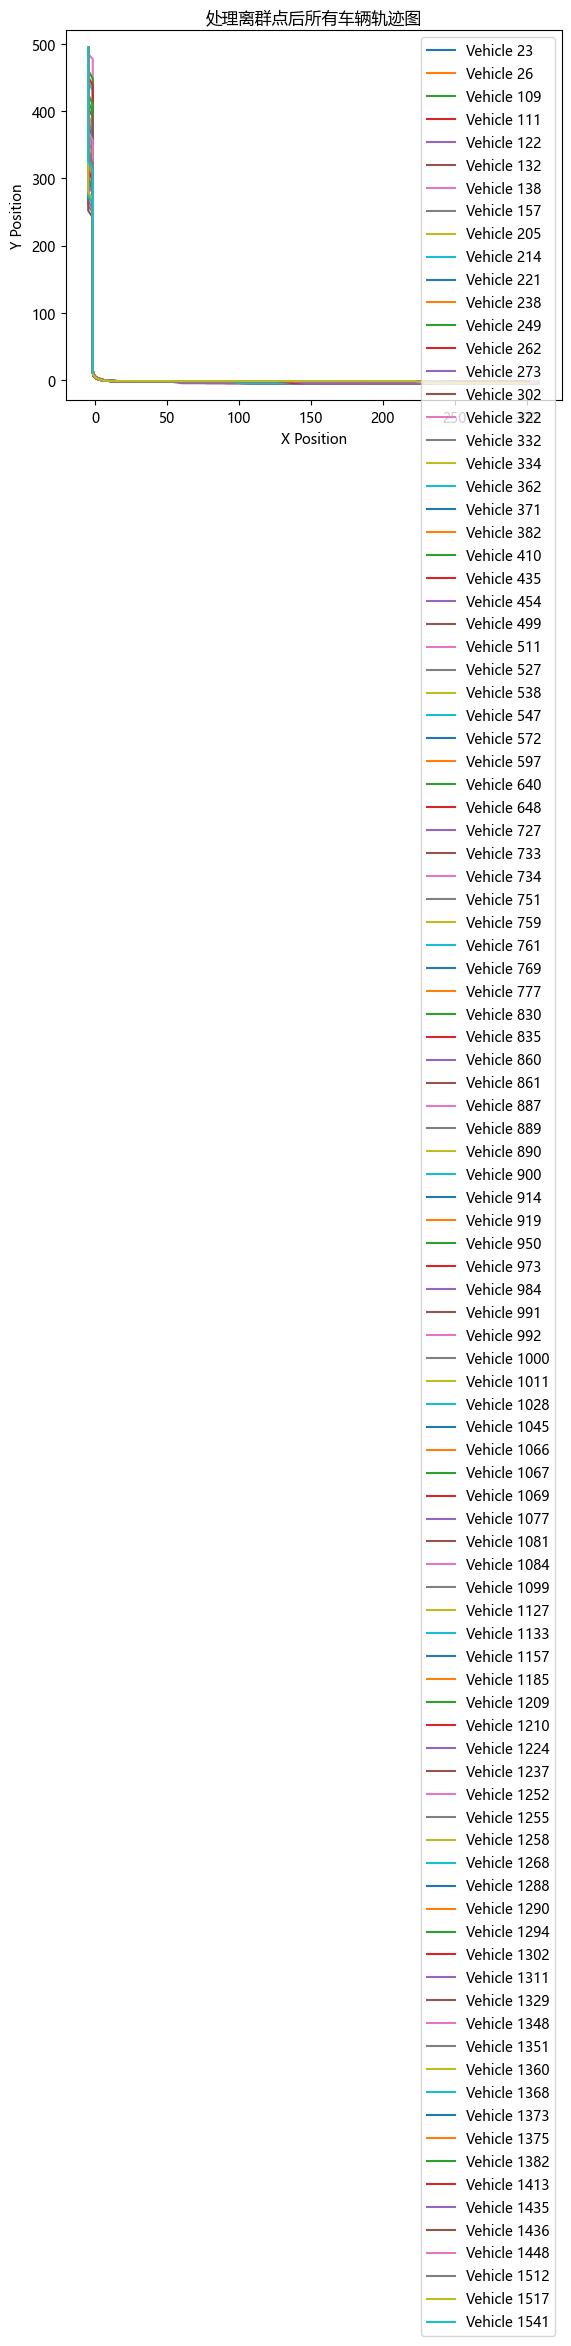

计算相对误差:
       time    x  x_smoothed  relative_error_x
0        53 -4.8        -4.8               0.0
1        54 -4.8        -4.8               0.0
2        55 -4.8        -4.8               0.0
3        56 -4.8        -4.8               0.0
4        57 -4.8        -4.8               0.0
...     ...  ...         ...               ...
11393  3595 -1.6        -1.6               0.0
11395  3596 -1.6        -1.6               0.0
11396  3597 -1.6        -1.6               0.0
11397  3598 -1.6        -1.6               0.0
11398  3599 -1.6        -1.6               0.0

[9957 rows x 4 columns]
       time       y  y_smoothed  relative_error_y
0        53  494.90  494.900000          0.000000
1        54  492.98  493.940000          0.001947
2        55  489.05  492.310000          0.006666
3        56  483.04  488.356667          0.011007
4        57  475.72  482.603333          0.014469
...     ...     ...         ...               ...
11393  3595   11.40   11.400000          0.000000
113

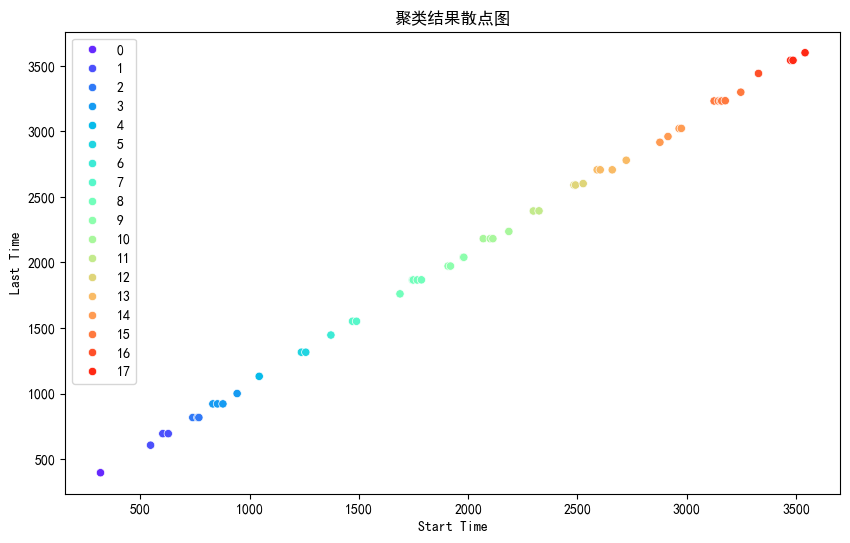

红灯时间： 74.33333333333334


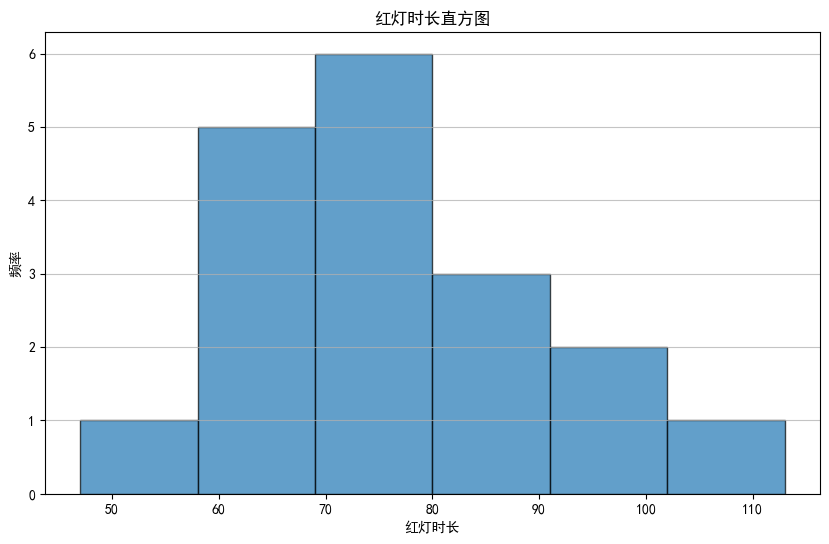

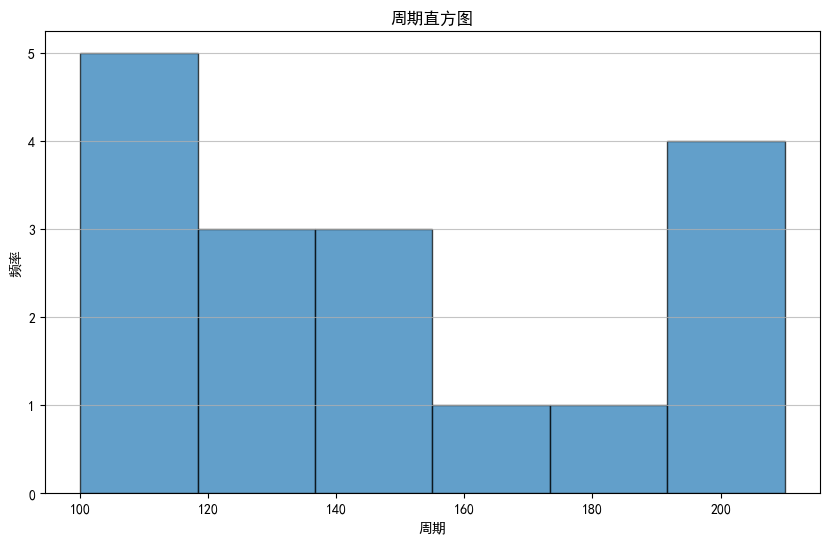

红绿灯周期: 109.16666666666666

5个数据集红灯时间的相对误差分别为： [0.10810810810810811, 0.027777777777777776, 0.17777777777777778, 0.08, 0.028169014084507043]
5个数据集红绿灯周期的相对误差分别为： [0.0761904761904762, 0.09615384615384616, 0.14736842105263157, 0.11904761904761904, 0.048295454545454544]


'对比后面几个文件的运行结果，看出定位误差为最小影响因素'

In [7]:
# 读取csv文件
address = r'D:/数学建模/数学建模/附件/附件1/A3.csv'  # 改变A1,A2,A3,A4,A5即可
data = pd.read_csv(address, encoding='gbk')

########################################### 1、IQR离群点检测 ###########################################
# 筛选需要处理的列
cols = ['x', 'y']

# 初始化离群点计数Series
outlier_counts_before = pd.Series(index=cols, dtype=int)
outlier_counts_after = pd.Series(index=cols, dtype=int)

# 处理离群点
for col in cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 识别离群点
    outliers = (data[col] < lower_bound) | (data[col] > upper_bound)
    outlier_counts_before[col] = outliers.sum()

    # 剔除离群点
    data = data[~outliers]

    # 再次检查离群点
    outliers_after = (data[col] < lower_bound) | (data[col] > upper_bound)
    outlier_counts_after[col] = outliers_after.sum()

# 打印原始和处理后的异常值计数
print("原始离群点计数:", outlier_counts_before)
print("处理后离群点计数:", outlier_counts_after)

# data.to_csv('dingweiwucha.csv', index=False)

######################################## 2、数据插值和平滑 #############################################
# 查看缺失值比例
print("查看缺失值比例：\n", data.isnull().sum()/len(data))
'''无缺失值'''
# 如果存在，用插值填补缺失值
data_interpolated = data.ffill()  # 使用前一个值填充

# 平滑数据（使用移动平均）
window_size = 3
data_smoothed = data_interpolated.copy()
data_smoothed['x_smoothed'] = data_interpolated['x'].rolling(window=window_size, min_periods=1).mean()
data_smoothed['y_smoothed'] = data_interpolated['y'].rolling(window=window_size, min_periods=1).mean()

# 处理离群点后的轨迹图
df = pd.DataFrame(data_smoothed, columns=['time', 'vehicle_id', 'x', 'y'])  # 创建DataFrame，并指定列名
fig, ax = plt.subplots()  # 创建一个新的图形和坐标轴
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置字体

# 遍历每个车辆ID，绘制轨迹
for vehicle_id, group in df.groupby('vehicle_id'):
    ax.plot(group['x'], group['y'], label=f'Vehicle {vehicle_id}')

ax.legend()  # 添加图例
ax.set_xlabel('X Position')  # 设置坐标轴标签
ax.set_ylabel('Y Position')
ax.set_title('处理离群点后所有车辆轨迹图')  # 设置标题
plt.show()  # 显示图形


########################################## 3、计算相对误差 ########################################
# 计算相对误差
data_e = data_smoothed.copy()
data_e['relative_error_x'] = np.abs((data_e['x_smoothed'] - data_e['x']) / data_e['x'])
data_e['relative_error_y'] = np.abs((data_e['y_smoothed'] - data_e['y']) / data_e['y'])
# 显示结果
print("计算相对误差:")
print(data_e[['time', 'x', 'x_smoothed', 'relative_error_x']])
print(data_e[['time', 'y', 'y_smoothed', 'relative_error_y']])


###################### 4、使用平滑后的数据计算红灯周期及信号灯周期（重复问题1中的模型） #######################
# 原始信号灯周期：104,95,105,88,88

# ********************** 计算速度 时间 （文件01_2）***********************
# 获取所有独特的车辆 ID
ID = data_smoothed['vehicle_id'].unique()

#  步骤一：计算车辆速度
for current_vehicle in ID:
    # 提取当前车辆的数据
    vehicle_data = data_smoothed[data_smoothed['vehicle_id'] == current_vehicle]

    # 对时间进行排序（确保数据按时间顺序）
    vehicle_data = vehicle_data.sort_values(by='time')

    # 提取 x, y 坐标和时间
    t = vehicle_data['time'].values
    x = vehicle_data['x_smoothed'].values
    y = vehicle_data['y_smoothed'].values

    # 计算空间距离差
    dx = np.diff(x)
    dy = np.diff(y)
    dt = np.diff(t)

    # 计算速度
    v = np.sqrt(dx ** 2 + dy ** 2) / dt

    # 将速度添加到数据集中
    data_smoothed.loc[data_smoothed['vehicle_id'] == current_vehicle, 'speed'] = np.concatenate(([0], v))

# 保存带有速度列的数据集到CSV文件
#data_smoothed.to_csv('02_1_data_speed.csv', index=False)

# 步骤2: 停车检测
speed_threshold = 1  # 速度阈值，单位m/s
start_stop_times = {}  # 存储开始停止的时间点
last_stop_times = {}  # 存储停车的最后一个时间点（速度为0的时刻）

for current_vehicle in ID:
    vehicle_data = data_smoothed[data_smoothed['vehicle_id'] == current_vehicle]
    low_speed_indices = np.where(vehicle_data['speed'] <= speed_threshold)[0]

    if len(low_speed_indices) > 0:
        # 开始停止的时间点是速度首次降至或低于阈值的时刻
        start_stop_time = vehicle_data.iloc[low_speed_indices[0]]['time']

        # 查找最后一个速度为0的索引
        zero_speed_indices = np.where(vehicle_data['speed'] == 0)[0]
        # 筛选出低速行驶期间内速度为0的索引
        filtered_zero_speed_indices = zero_speed_indices[
            (zero_speed_indices >= low_speed_indices[0]) & (zero_speed_indices <= low_speed_indices[-1])]

        if len(filtered_zero_speed_indices) > 0:
            # 如果有速度为0的时刻，取最后一个
            last_stop_time = vehicle_data.iloc[filtered_zero_speed_indices[-1]]['time']
        else:
            # 如果没有速度为0的时刻，取特殊值来表示没有停车
            last_stop_time = None

        # 存储结果
        start_stop_times[current_vehicle] = start_stop_time
        last_stop_times[current_vehicle] = last_stop_time

# 步骤3: 筛选有效的停车数据
min_stop_duration = 10  # 最小停车时长，单位秒
filtered_data = []
for vehicle_id, start_time in start_stop_times.items():
    last_time = last_stop_times.get(vehicle_id)
    # 输出结果
    #print(f"Vehicle {vehicle_id}: Started stopping at {start_time}, last stop (speed=0) time at {last_time}")
    # 筛选有效的停车数据，剔除停车时长<10的数据
    if last_time is not None:
        # 计算时间差
        time_diff = last_time - start_time
        if time_diff >= min_stop_duration:
            # 将时间差（或其他特征）添加到列表中
            filtered_data.append((vehicle_id, start_time, last_time, time_diff))

#print(filtered_data)
# 写入CSV文件
with open('02_1_data_time.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    # 写入表头
    writer.writerow(['vehicle_id', 'start_time', 'last_time', 'time_diff'])
    # 写入数据
    for row in filtered_data:
        writer.writerow(row)

# ******************************* 计算红灯时间及周期 （文件01_3）******************
# 读取数据
data = pd.read_csv("D:\数学建模\数学建模\代码\第二次/02_1_data_time.csv")
data = pd.DataFrame(data, columns=['start_time', 'last_time'])
# 特征缩放
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# DBSCAN参数搜索
num_random_search = 100
eps_values = np.linspace(0.01, 0.15, num_random_search)
min_samples_values = np.arange(1, 2)
best_silhouette = -np.inf
best_params = {'eps': None, 'min_samples': None}

for eps in eps_values:
    for min_samples in min_samples_values:
        # 使用当前参数进行DBSCAN聚类
        dbscan_result = DBSCAN(eps=eps, min_samples=min_samples).fit(data_scaled)
        cluster_labels = dbscan_result.labels_

        # 如果聚类结果不是全为-1（即存在非噪声点）
        if len(set(cluster_labels)) > 1:
            silhouette_avg = silhouette_score(data, cluster_labels)
            if silhouette_avg > best_silhouette:
                best_silhouette = silhouette_avg
                best_params['eps'] = eps
                best_params['min_samples'] = min_samples

            # 输出最佳参数和轮廓系数
print("最佳参数和轮廓系数:", best_params)
print("Best Silhouette Score:", best_silhouette)

# 使用最佳参数进行聚类
final_dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples']).fit(data_scaled)
final_cluster_labels = final_dbscan.labels_

# 将缩放后的数据转换回 DataFrame 形式（但注意，这里的值已经是缩放后的，不适合直接解释）
data_scaled_df = pd.DataFrame(data_scaled, columns=['start_time', 'last_time'])

# 使用原始数据来计算红灯时长和周期
data_with_labels = pd.DataFrame(data, columns=['start_time', 'last_time'])
data_with_labels['cluster'] = final_cluster_labels

# 使用原始数据来可视化聚类结果
plt.figure(figsize=(10, 6))
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体为黑体
sns.scatterplot(data=data_with_labels, x='start_time', y='last_time',
                hue=pd.Categorical.from_codes(final_cluster_labels, categories=np.unique(final_cluster_labels)),
                palette='rainbow')
plt.title("聚类结果散点图")
plt.xlabel("Start Time")
plt.ylabel("Last Time")
plt.show()

###################################### 红灯时长 ##################################################
# 计算每个簇的红灯时长平均值
red_light_durations = {}
for cluster in np.unique(final_cluster_labels):
    if cluster != -1:  # 忽略噪声点
        cluster_data = data_with_labels[data_with_labels['cluster'] == cluster]
        red_light_durations[cluster] = cluster_data['last_time'].subtract(cluster_data['start_time']).mean()

    # 输出每个簇的红灯时长
# print("Red Light Durations for each cluster:", red_light_durations)
# 计算红灯时长中位数
average_red_light_duration = np.median(list(red_light_durations.values()))
print("红灯时间：", average_red_light_duration)


# 绘制红灯时长直方图
plt.figure(figsize=(10, 6))
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体为黑体
cluster_durations = list(red_light_durations.values())
plt.hist(cluster_durations, bins='auto', alpha=0.7, edgecolor='black')
plt.xlabel('红灯时长')
plt.ylabel('频率')
plt.title('红灯时长直方图')
plt.grid(axis='y', alpha=0.75)
plt.show()


##################################### 红绿灯周期 #################################
# 找出每个簇中的时间点'last_time'（作为周期结束的代表）
# 因为每个簇代表一波车流
# 首先，我们创建一个字典来存储每个簇的 'last_time' 的最大值和最小值
cluster_last_time_extremes = {}
for cluster in np.unique(final_cluster_labels):
    if cluster != -1:
        cluster_data = data_with_labels[data_with_labels['cluster'] == cluster]
        cluster_last_time_extremes[cluster] = {'min': cluster_data['last_time'].min(),
                                               'max': cluster_data['last_time'].max()}
        # cluster_last_times[cluster] = cluster_data['last_time'].median()  # 选择2：使用中位数作为代表

    # 计算簇与簇之间'last_time'的差（作为周期），使用第二个簇的最小值减去第一个簇的最大值
periods = []
clusters = sorted(cluster_last_time_extremes.keys())
for i in range(len(clusters) - 1):
    diff = cluster_last_time_extremes[clusters[i + 1]]['min'] - cluster_last_time_extremes[clusters[i]]['max']
    # diff = cluster_last_times[clusters[i + 1]] - cluster_last_times[clusters[i]]  # 选择2
    periods.append(diff)

# 绘制周期直方图
plt.figure(figsize=(10, 6))
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体为黑体
plt.hist(periods, bins='auto', alpha=0.7, edgecolor='black')
plt.xlabel('周期')
plt.ylabel('频率')
plt.title('周期直方图')
plt.grid(axis='y', alpha=0.75)
plt.show()

# 使用 numpy 的 histogram 函数找到频率最高的周期
counts, bin_edges = np.histogram(periods, bins='auto')
max_index = np.argmax(counts)  # 找到计数最多的bin的索引
most_common_period_bin = 0.5 * (bin_edges[max_index] + bin_edges[max_index + 1])  # 计算该bin的中心点作为周期的代表
if most_common_period_bin > 500:
    most_common_period_bin = most_common_period_bin/5
elif most_common_period_bin > 400:
    most_common_period_bin = most_common_period_bin / 4
elif most_common_period_bin > 300:
    most_common_period_bin = most_common_period_bin / 3
elif most_common_period_bin > 200:
    most_common_period_bin = most_common_period_bin / 2
elif most_common_period_bin > 150:
    most_common_period_bin = most_common_period_bin / 2
print(f"红绿灯周期: {most_common_period_bin}")  # 最常见的周期 bin 相对应的中位数


################################## 求红灯时间及红绿灯周期的相对误差 ###################################

#################################### 计算红灯时间相对误差
red = [74, 72, 90, 75, 71]
red_smooth = [82, 74, 74, 69, 73]
relative_errors = []  # 初始化一个空列表来存储相对误差

# 计算5个数据集红灯时间的相对误差
for original, smoothed in zip(red, red_smooth):
    relative_error = (abs(smoothed - original) / original)
    relative_errors.append(relative_error)

print('\n5个数据集红灯时间的相对误差分别为：', relative_errors)

########################## 计算红绿灯周期相对误差
cyc = [105, 104, 95, 105, 88, 88]
cyc_smooth = [97, 114, 109, 92.5, 92.25]
cyc_relative_errors = []  # 初始化一个空列表来存储相对误差

# 计算5个数据集红绿灯周期的相对误差
for original, smoothed in zip(cyc, cyc_smooth):
    cyc_relative_error = (abs(smoothed - original) / original)
    cyc_relative_errors.append(cyc_relative_error)

print('5个数据集红绿灯周期的相对误差分别为：', cyc_relative_errors)

# 运行结果：
'''
5个数据集红灯时间的相对误差分别为： [0.10810810810810811, 0.027777777777777776, 0.17777777777777778, 0.08, 0.028169014084507043]
5个数据集红绿灯周期的相对误差分别为： [0.0761904761904762, 0.09615384615384616, 0.14736842105263157, 0.11904761904761904, 0.048295454545454544]
'''

'''对比后面几个文件的运行结果，看出定位误差为最小影响因素'''